# 4. Analysing urban patterns: metrics, statistics, applications

In this class, we will understand why and how space matters when working with urban data, what to watch out out for, how to describe urban patterns, identify hotspots, and extract meaningful information from urban spatial data.

In [1]:
# import warnings
# warnings.filterwarnings('ignore')
# warnings.simplefilter('ignore')
import esda
import libpysal as lps
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd, networkx as nx
import osmnx as ox
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
import shapely
from pyproj import CRS
from tqdm import tqdm_notebook
from itertools import combinations, combinations_with_replacement
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

C:\Users\gevor\anaconda3\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.4.3-CAPI-1.8.3 r4285) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
# in case of encountering problems with GEOS or GDAL, disable speedups from shapely
from shapely import speedups
speedups.disable()

We will start with loading GPS vehicle data in London, aggregating it into quadratic cells that we will divide the territory of the city into, and analyse the resulting spatial patterns.

In [3]:
# import gps data set
data = pd.read_csv('../data/LR_17.csv', \
                   header=0, index_col=0, nrows=5*10**6)
print(len(data))
data.tail()

C:\Users\gevor\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


5000000


,uid,ts,lat,lon,speed,heading,gps_quality,status,odometer
4999995,366302,2015-11-22 15:00:01,41.973389,12.249760,68,218,3,1,520
4999996,366302,2015-11-22 15:00:31,41.970425,12.245254,58,236,3,1,504
4999997,366302,2015-11-22 15:01:01,41.966950,12.242278,62,220,3,1,473
4999998,366302,2015-11-22 15:01:31,41.963112,12.237378,70,230,3,1,591
4999999,366302,2015-11-22 15:02:01,41.960209,12.231494,64,226,3,1,588


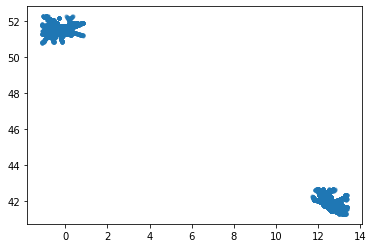

In [4]:
# plot a sample of GPS points
plt.scatter(data.loc[:100000, 'lon'],data.loc[:100000, 'lat'], alpha=0.5, s=10)
plt.show()

In [5]:
print(len(data))
data_london = data.loc[(data.lon <= 0.3350155) & \
                (data.lat <= 51.6928741) & (data.lon >= -0.5113751) & (data.lat >= 51.2847601)]
print(len(data_london))

5000000
937163


In [6]:
data_london = data_london.drop(['heading', 'gps_quality', 'status', 'odometer', 'speed'], axis=1)
data_london.tail()

,uid,ts,lat,lon
4984682,366252,2015-05-25 04:55:13,51.567145,0.110719
4984683,366252,2015-05-25 04:58:53,51.570374,0.089155
4984684,366252,2015-05-25 05:04:24,51.574932,0.093186
4984685,366252,2015-05-25 12:39:07,51.574968,0.093145
4984686,366252,2015-05-25 12:45:34,51.565845,0.106096


In [7]:
data_london.reset_index(drop=True, inplace=True)
data_london.tail()

,uid,ts,lat,lon
937158,366252,2015-05-25 04:55:13,51.567145,0.110719
937159,366252,2015-05-25 04:58:53,51.570374,0.089155
937160,366252,2015-05-25 05:04:24,51.574932,0.093186
937161,366252,2015-05-25 12:39:07,51.574968,0.093145
937162,366252,2015-05-25 12:45:34,51.565845,0.106096


In [8]:
# create Point geometries from lat and lon coordinates
geometry = [Point(xy) for xy in zip(data_london.lon, data_london.lat)] #list comprehension
crs = CRS.from_epsg(4326)
gdf_london = gpd.GeoDataFrame(data_london, crs=crs, geometry=geometry)
gdf_london.head()

,uid,ts,lat,lon,geometry
0,309202,2015-01-02 07:35:27,51.298340,-0.484500,POINT (-0.48450 51.29834)
1,309202,2015-01-02 07:36:33,51.311786,-0.466551,POINT (-0.46655 51.31179)
2,309202,2015-01-02 07:38:52,51.321377,-0.447033,POINT (-0.44703 51.32138)
3,309202,2015-01-02 07:40:02,51.311135,-0.423430,POINT (-0.42343 51.31114)
4,309202,2015-01-02 07:41:07,51.306351,-0.396195,POINT (-0.39619 51.30635)


In [9]:
# load Yerevan grid data file we created earlier
address = "../data/London shapefile/london.shp"
london = gpd.read_file(address)
print(london.crs)
london.head()

epsg:32630


,FID,geometry
0,0,"POLYGON ((672920.208 5704819.744, 672921.309 5..."


Let's plot the London polygon geometry:

<AxesSubplot:>

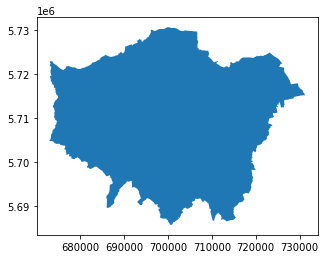

In [10]:
london.plot()

Now, let's subdivide the London polygon geometry into a homogeneous grid of 1500 x 1500 meter quadratic grid cells.

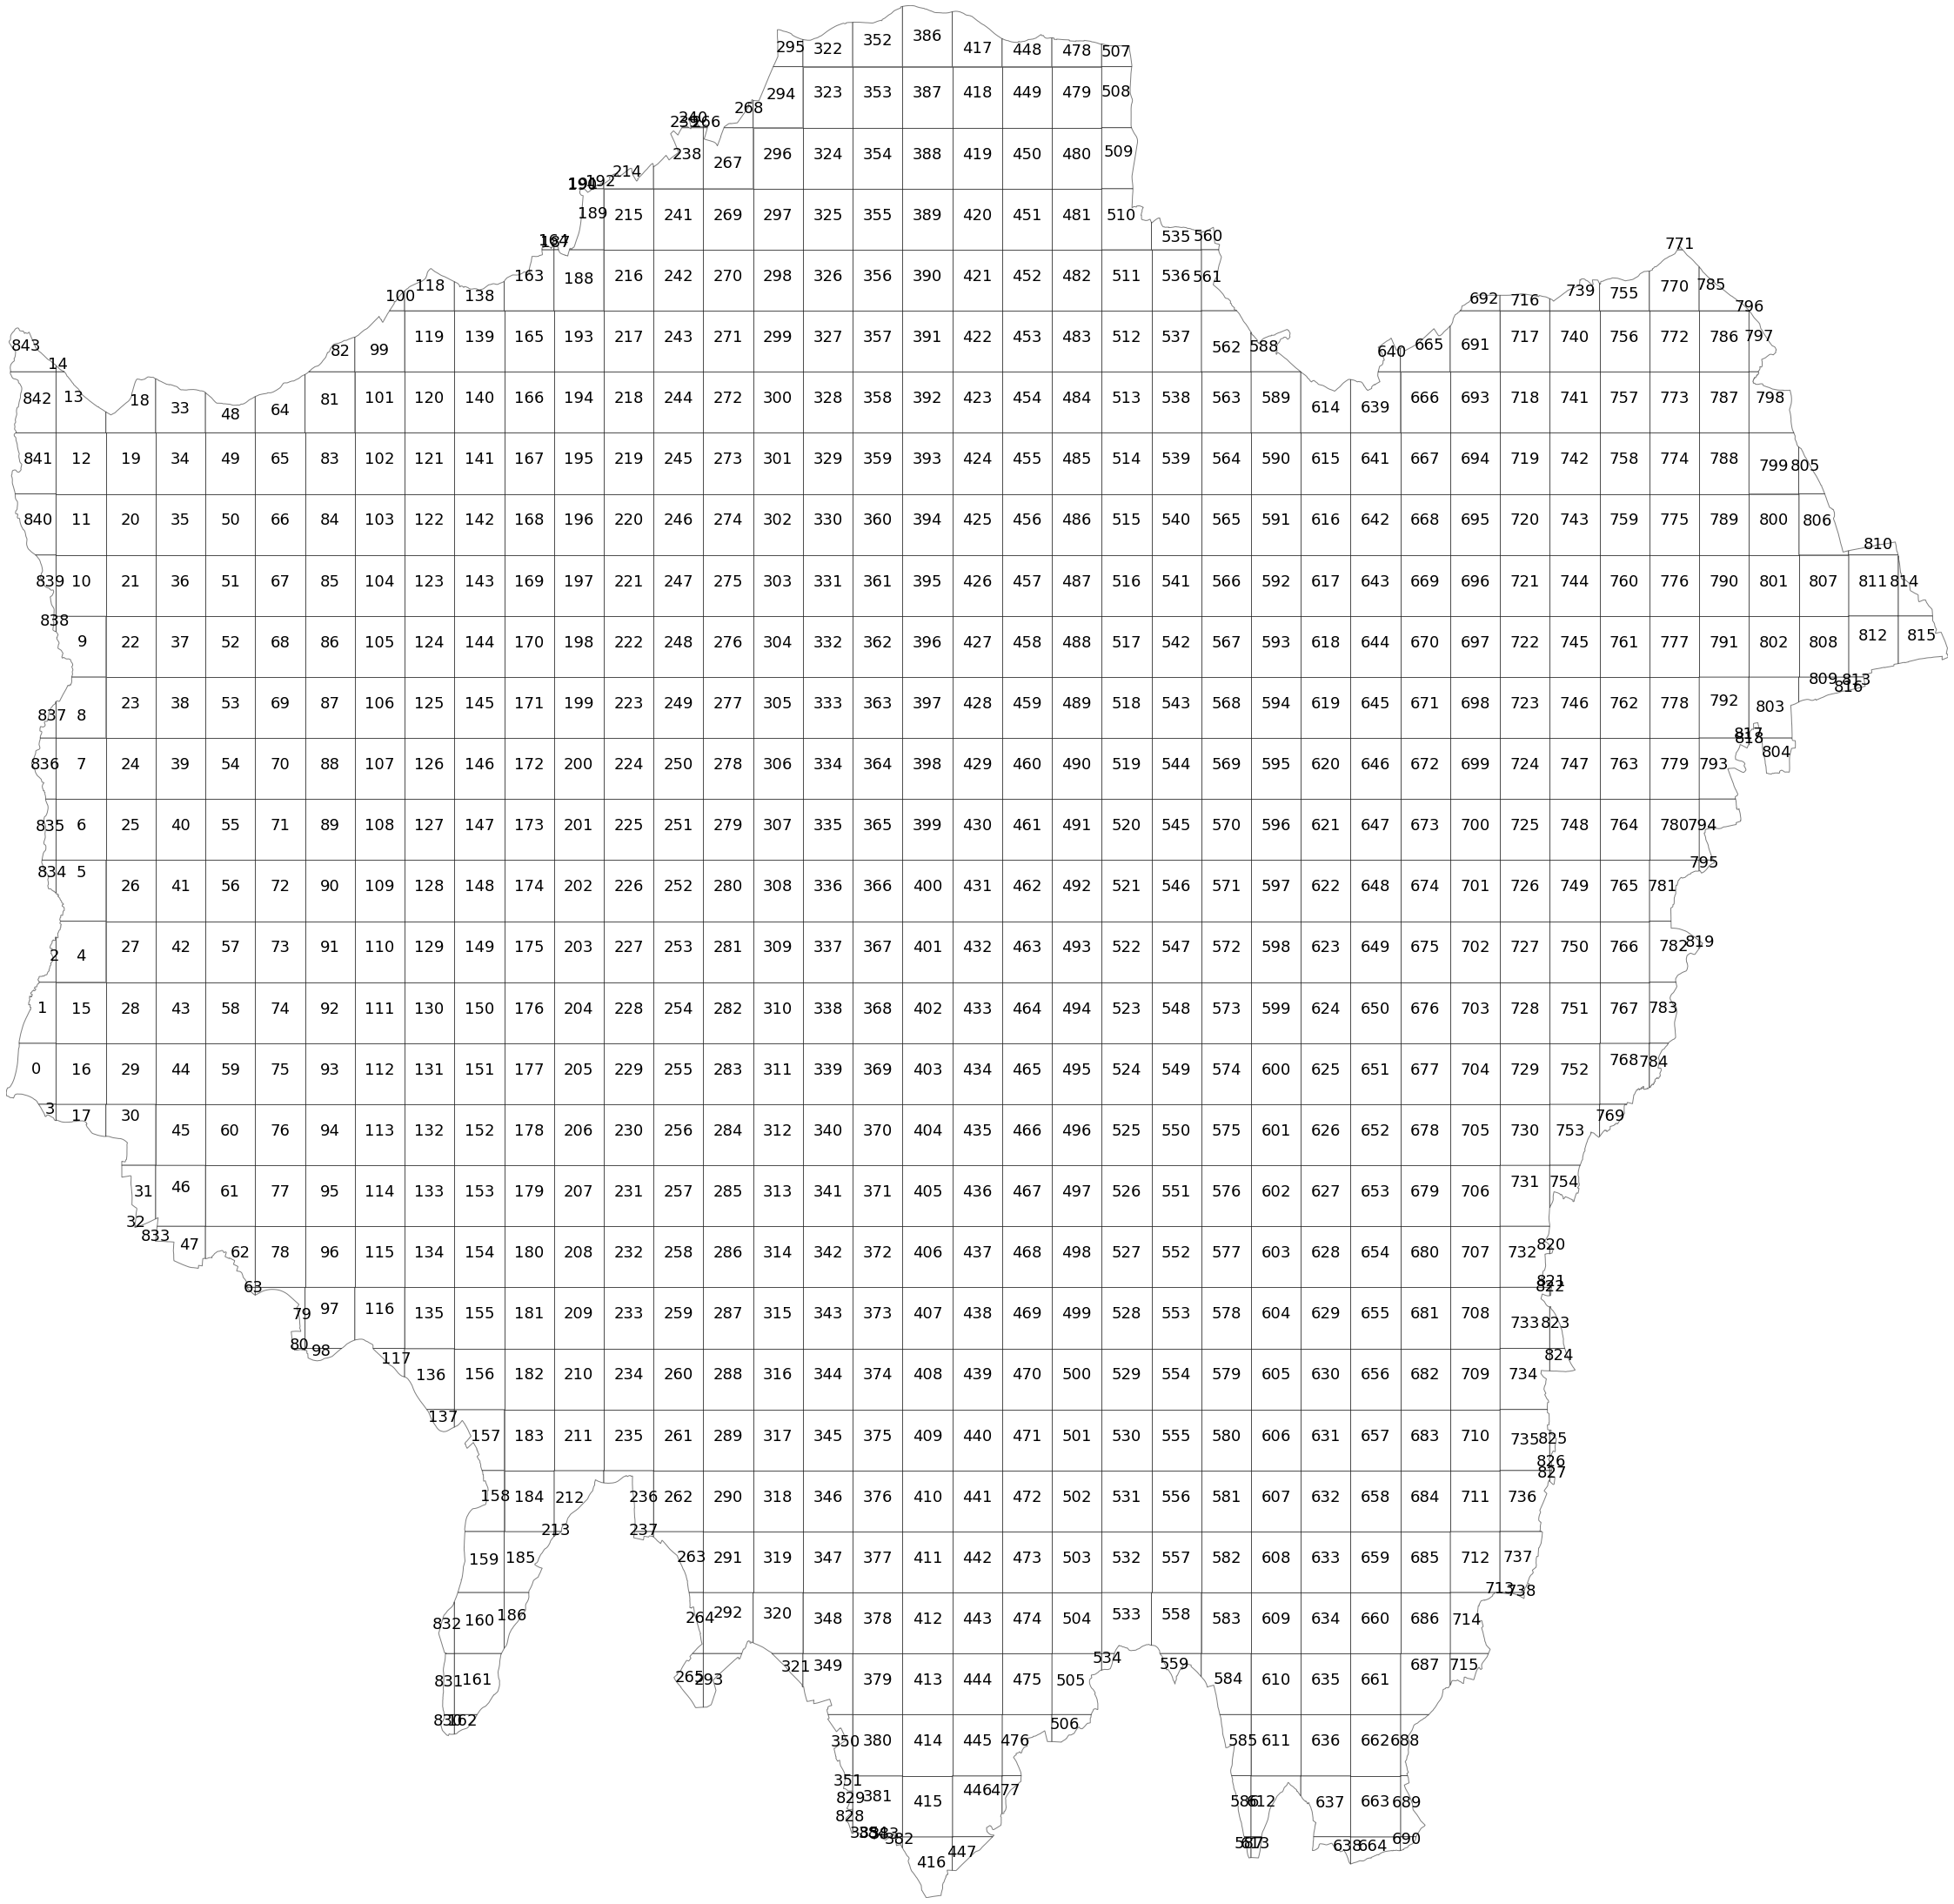

In [11]:
# make the geometry a multipolygon if it's not already
geometry = london['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.utils_geo._quadrat_cut_geometry(geometry, quadrat_width=1500)

london['coords'] = london['geometry'].apply(lambda x: x.representative_point().coords[:])
london['coords'] = [coords[0] for coords in london['coords']]

polylist = [p for p in geometry_cut]

west, south, east, north = london.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,40))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    plt.annotate(text=n, xy=p,
                 horizontalalignment='center', size=18)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

In [12]:
polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = london.geometry.crs
polyframe.head()

,geometry
0,"POLYGON ((672920.208 5704819.744, 672921.309 5..."
1,"POLYGON ((673305.142 5706006.649, 673305.518 5..."
2,"POLYGON ((673904.607 5707461.237, 673904.770 5..."
3,"POLYGON ((674414.245 5704552.061, 674414.245 5..."
4,"POLYGON ((674414.245 5708534.489, 674418.111 5..."


In [13]:
#reproject geometry to London grid crs
print(gdf_london.crs)
gdf_london.geometry = gdf_london.geometry.to_crs(polyframe.crs)
print(gdf_london.crs)
gdf_london.head()

epsg:4326
epsg:32630


,uid,ts,lat,lon,geometry
0,309202,2015-01-02 07:35:27,51.298340,-0.484500,POINT (675364.997 5686007.406)
1,309202,2015-01-02 07:36:33,51.311786,-0.466551,POINT (676564.485 5687545.460)
2,309202,2015-01-02 07:38:52,51.321377,-0.447033,POINT (677887.448 5688658.996)
3,309202,2015-01-02 07:40:02,51.311135,-0.423430,POINT (679571.835 5687577.739)
4,309202,2015-01-02 07:41:07,51.306351,-0.396195,POINT (681488.552 5687112.846)


In [14]:
# Here we carry out a spatial join operation, identifying which GPS point falls into which polygon. 
# This is similar to classic join operations in relational database structures (e.g., SQL)
cells_vehicle_counts = gpd.sjoin(polyframe, gdf_london, op='contains')
cells_vehicle_counts.head()

,geometry,index_right,uid,ts,lat,lon
0,"POLYGON ((672920.208 5704819.744, 672921.309 5...",371546,331982,2015-06-27 12:20:57,51.466057,-0.497074
0,"POLYGON ((672920.208 5704819.744, 672921.309 5...",164756,319262,2015-03-28 07:40:44,51.466141,-0.497062
0,"POLYGON ((672920.208 5704819.744, 672921.309 5...",88016,315332,2015-06-02 18:56:39,51.474212,-0.496253
0,"POLYGON ((672920.208 5704819.744, 672921.309 5...",334689,330192,2015-11-27 18:11:43,51.466140,-0.497090
0,"POLYGON ((672920.208 5704819.744, 672921.309 5...",641172,350912,2015-04-20 17:18:04,51.466256,-0.497127


In [15]:
# we aggregate the GPS point counts
vehicle_counts = cells_vehicle_counts.groupby(cells_vehicle_counts.index)['index_right'].count()
counts = pd.DataFrame(vehicle_counts)
counts.columns = ['counts']
counts

,counts
0,1360
1,979
2,167
3,94
4,901
...,...
837,33
840,5
841,14
842,3


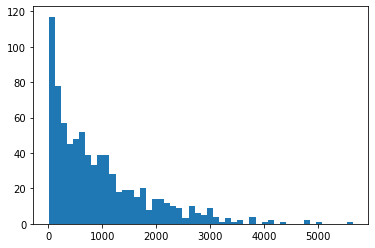

In [16]:
# plot a quick histogram to check the data distribution
plt.hist(counts.counts, bins=50)
plt.show()

In [17]:
polycounts = polyframe.copy()
polycounts['counts'] = counts.counts
polycounts['counts'].fillna(0, inplace=True)
polycounts['counts'] = polycounts['counts'].astype(int)
polycounts

,geometry,counts
0,"POLYGON ((672920.208 5704819.744, 672921.309 5...",1360
1,"POLYGON ((673305.142 5706006.649, 673305.518 5...",979
2,"POLYGON ((673904.607 5707461.237, 673904.770 5...",167
3,"POLYGON ((674414.245 5704552.061, 674414.245 5...",94
4,"POLYGON ((674414.245 5708534.489, 674418.111 5...",901
...,...,...
839,"POLYGON ((674342.676 5716188.766, 674344.572 5...",0
840,"POLYGON ((673795.529 5717643.355, 673782.836 5...",5
841,"POLYGON ((673186.499 5719097.943, 673185.893 5...",14
842,"POLYGON ((673204.890 5720552.531, 673211.418 5...",3


In [18]:
polycounts[polycounts['counts']==polycounts['counts'].max()]

,geometry,counts
278,"POLYGON ((695330.770 5713279.590, 695330.770 5...",5648


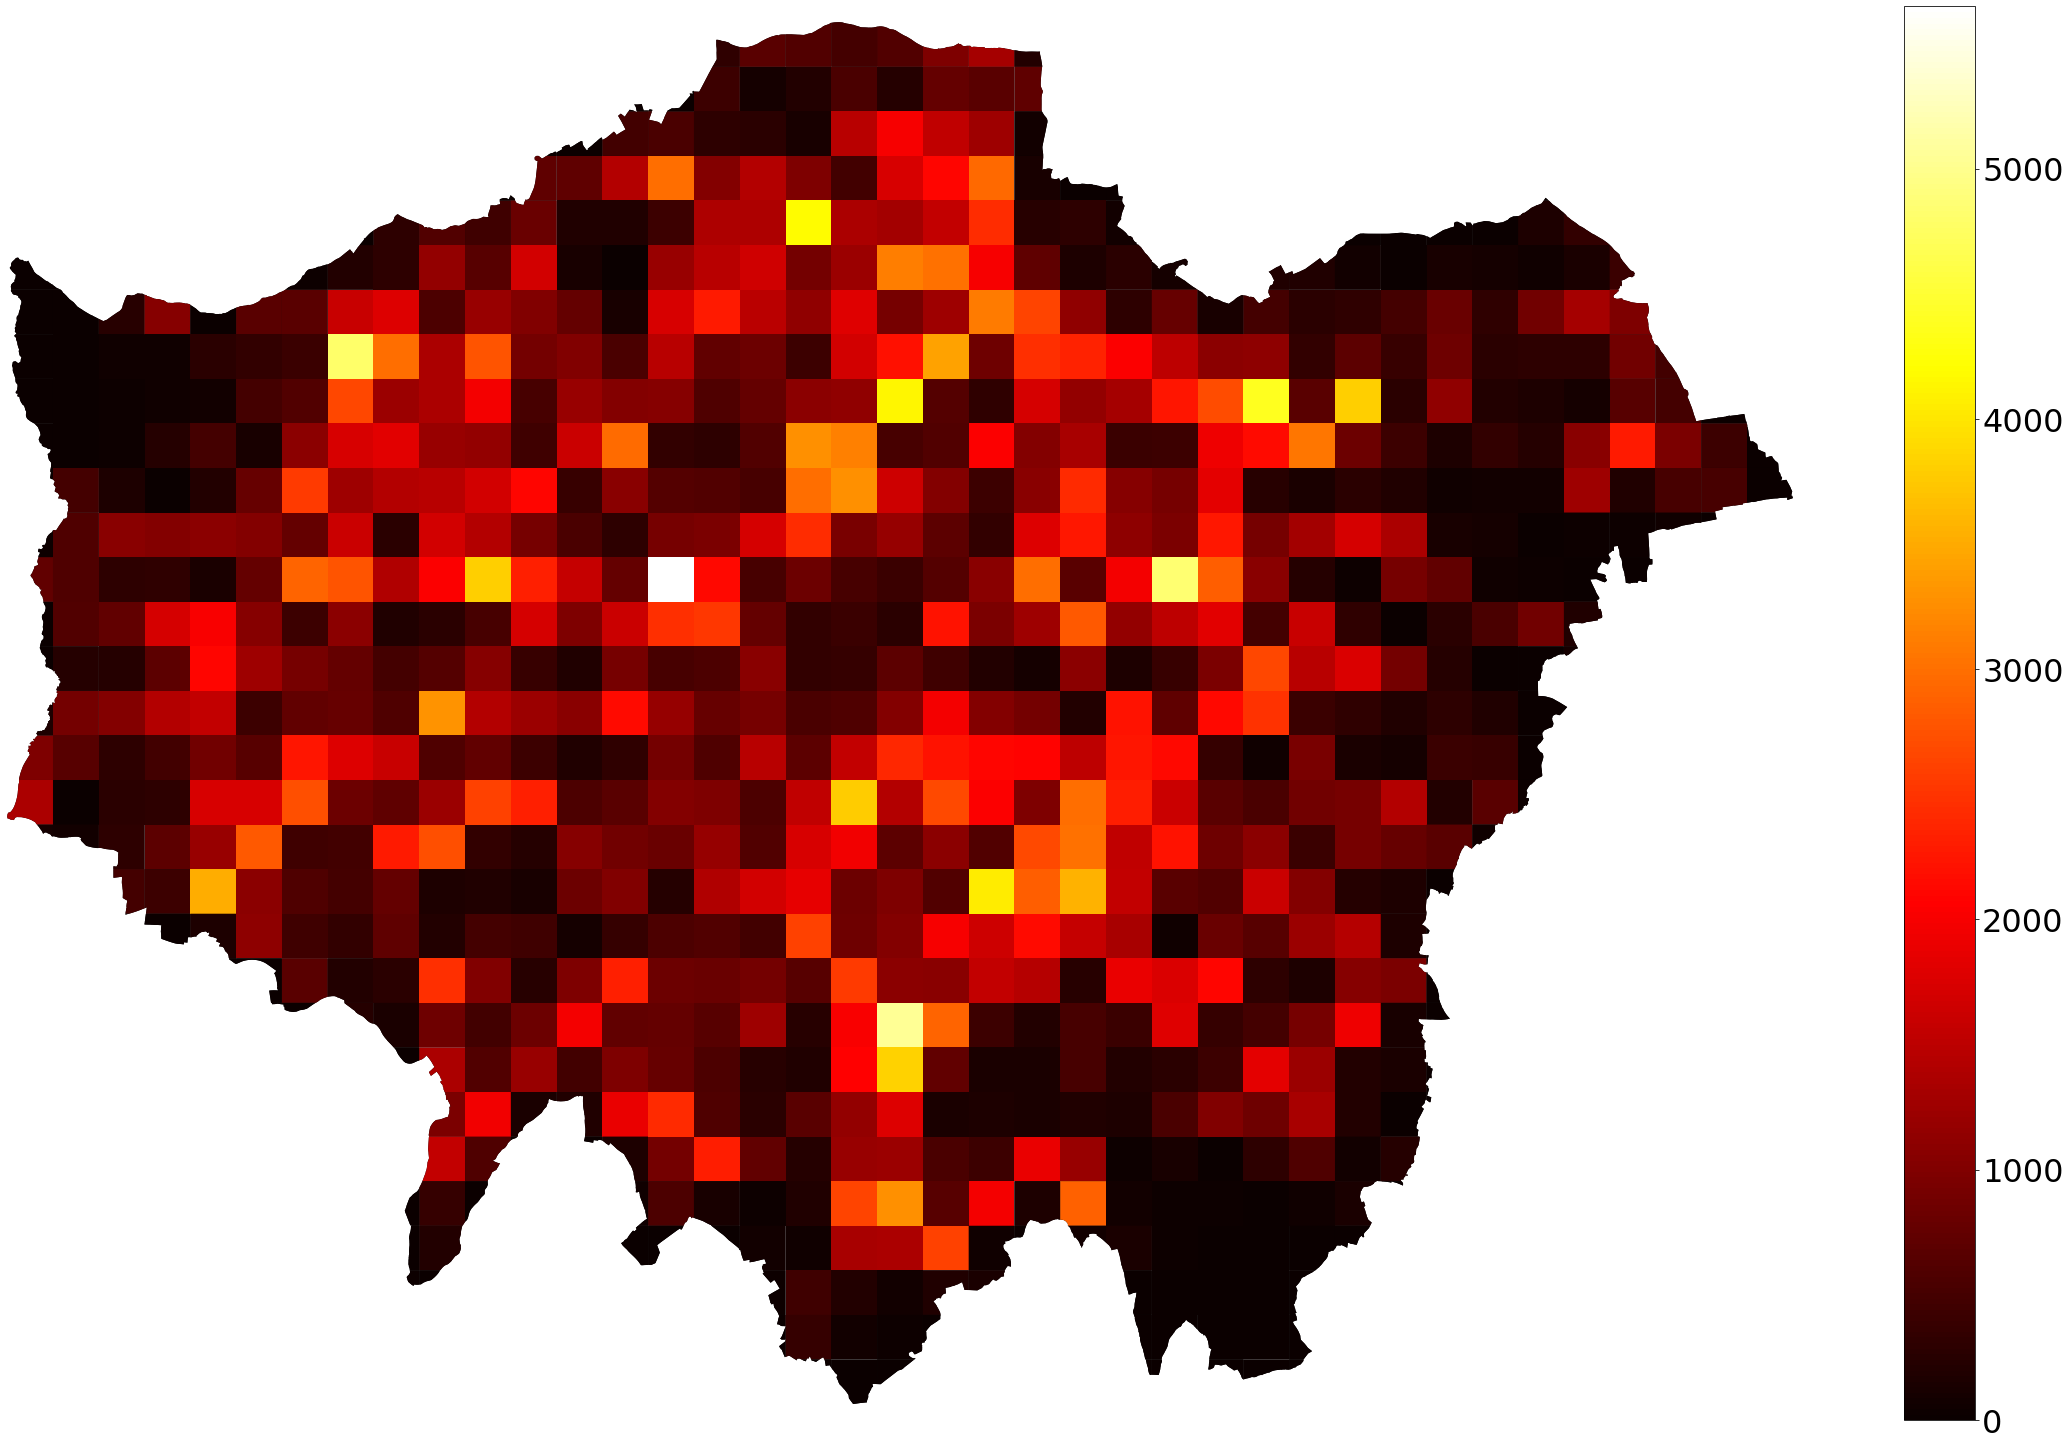

In [19]:
# plot the restaurant count distribution
plt.rcParams.update({'font.size':32})
west, south, east, north = polyframe.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
polycounts.plot(column='counts',  legend=True, cmap='hot', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

Now we will keep the count values (i.e., the data distribution), but will randomly reshuffle it, assigning each aggregated value count to a different grid cell polygon. We will later see the purpose of this exercise.

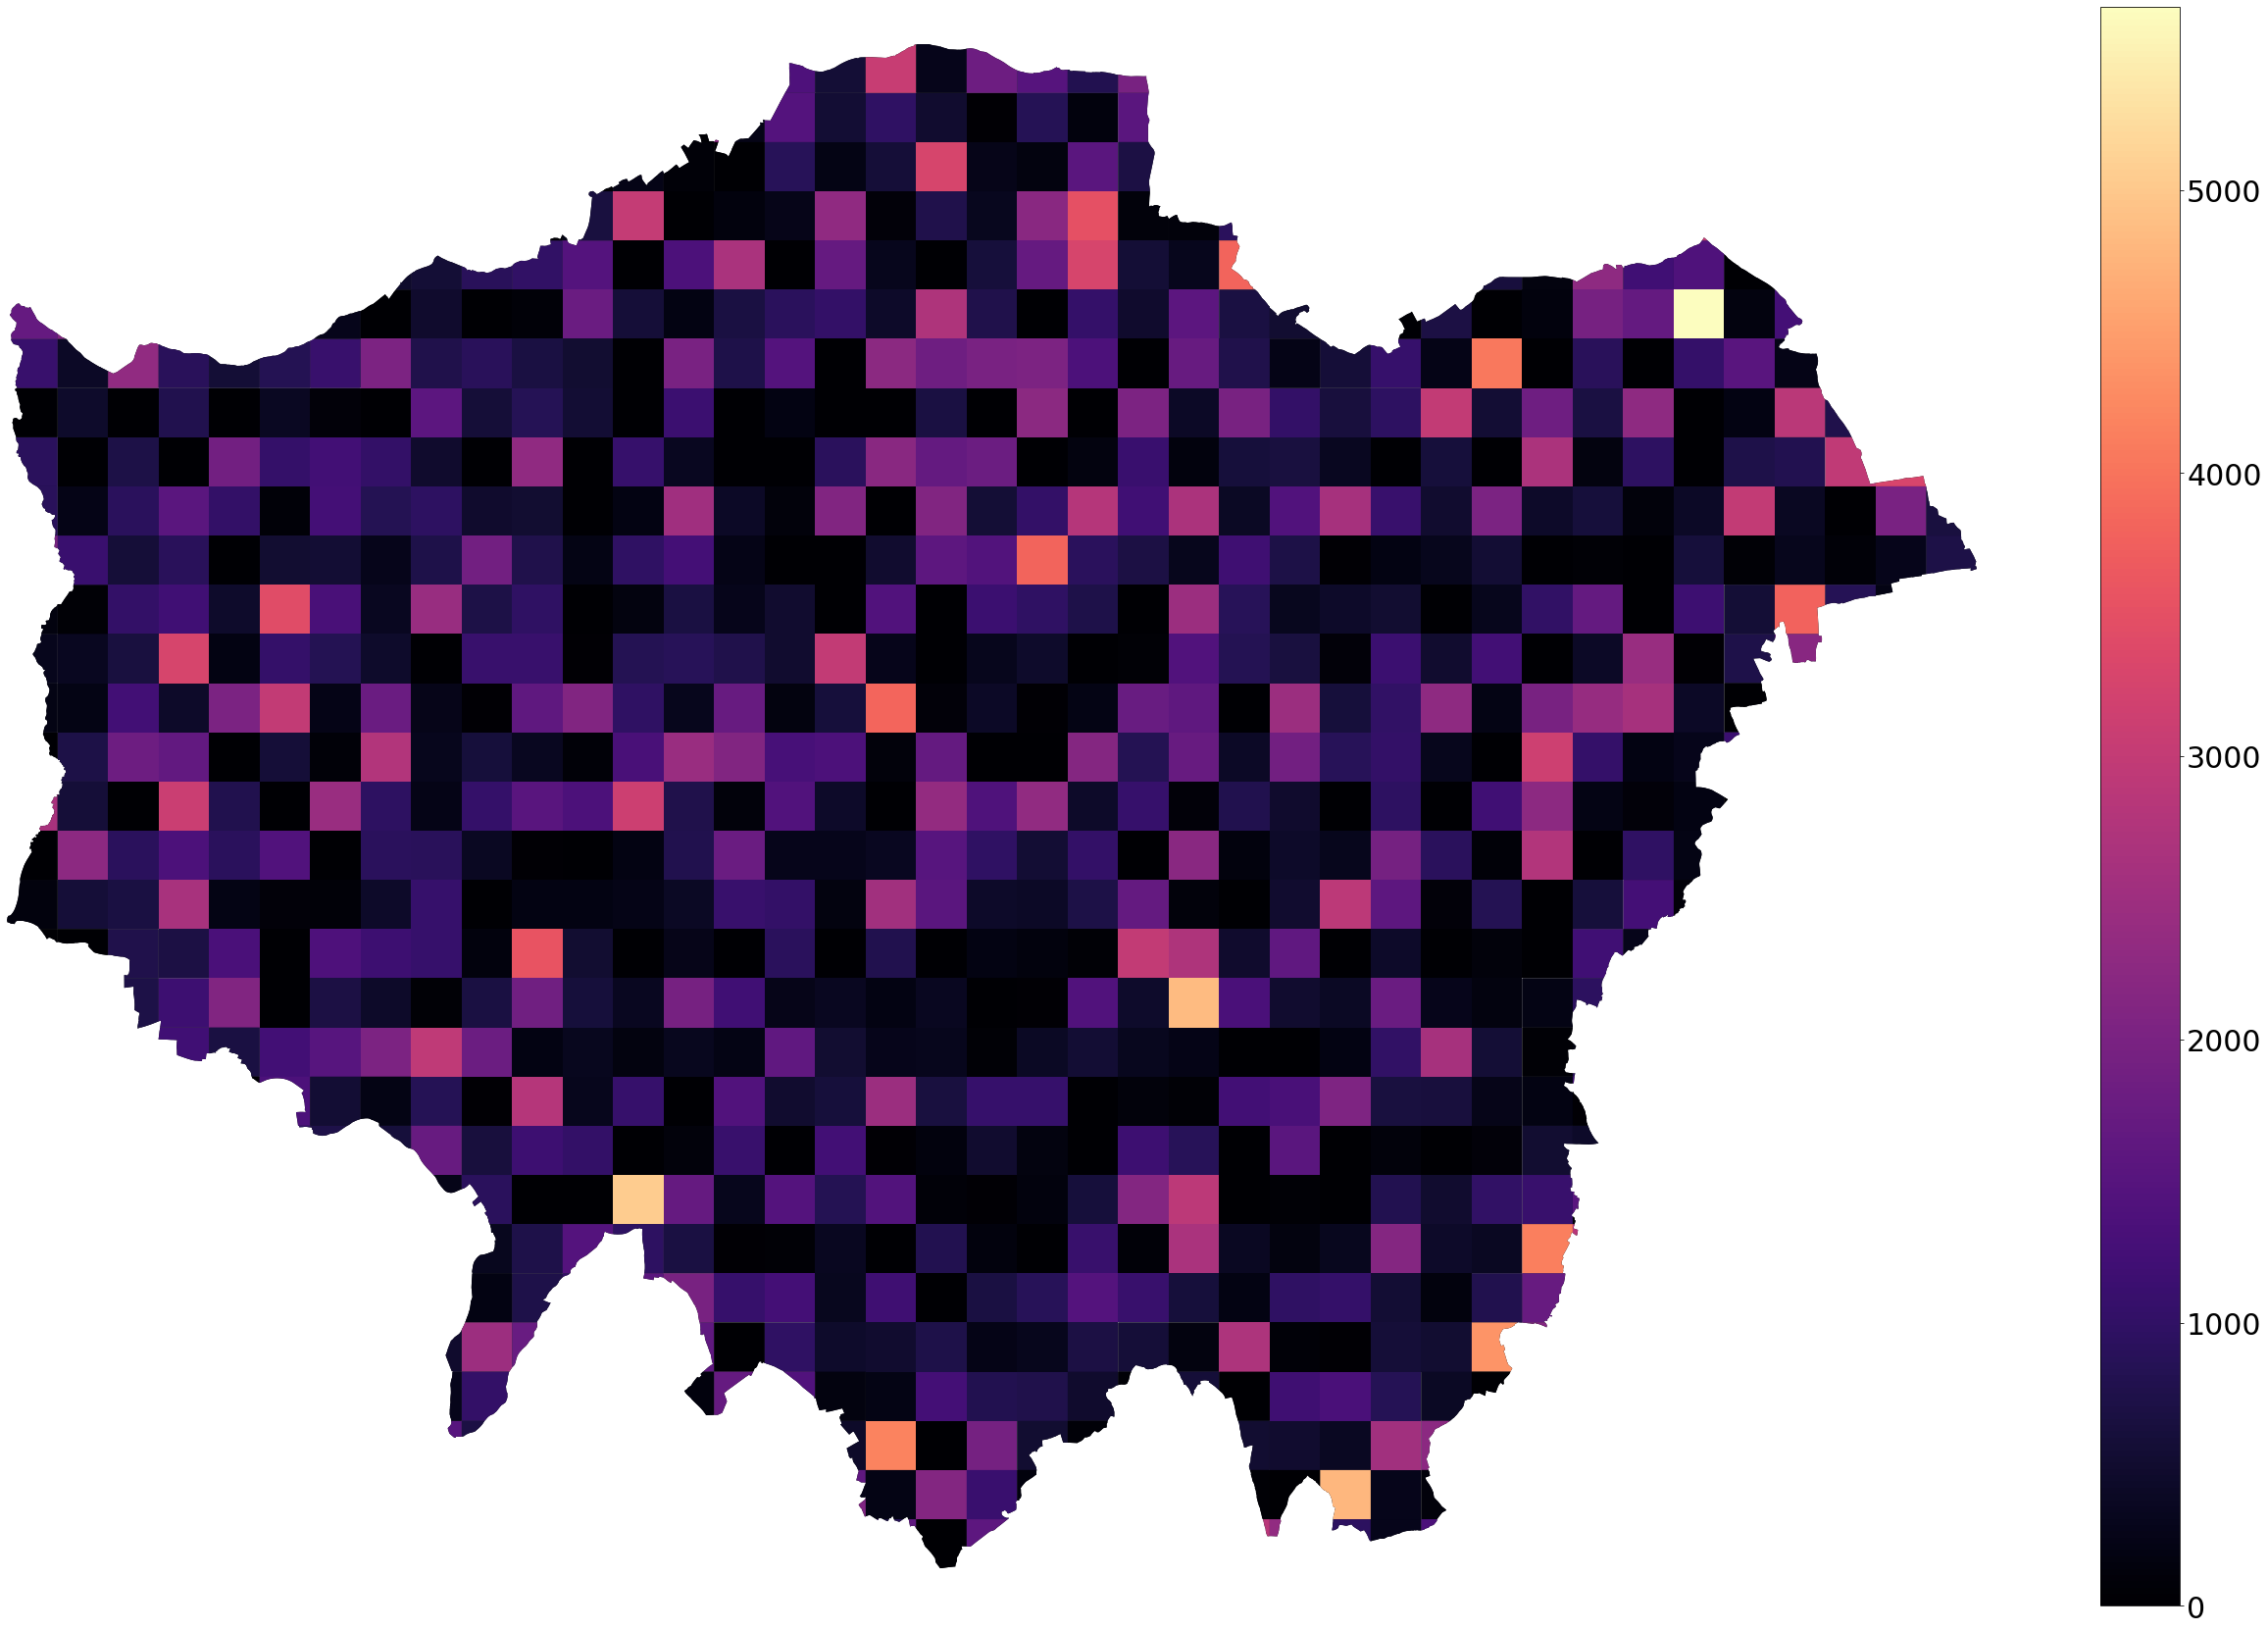

In [20]:
# we do the permutations
polycount_shuffled = polycounts.copy()
polycount_shuffled['counts_shuffled'] = np.random.permutation(polycount_shuffled['counts'].values)

# and plot it

# plot the city
plt.rcParams.update({'font.size': 30})
west, south, east, north = polyframe.unary_union.bounds
fig, ax = plt.subplots(figsize=(45,30))
polyframe.plot(ax=ax, color='#000004')
polycount_shuffled.plot(column='counts_shuffled',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')

plt.show()

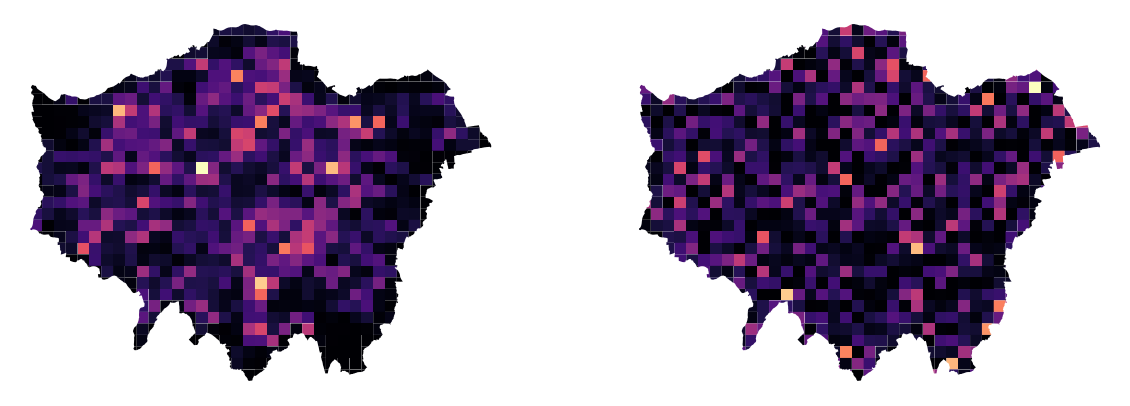

In [21]:
plt.rcParams.update({'font.size':20})
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,8))  # 1 row, 2 columns
polycounts.plot(column='counts', cmap='magma', ax=ax1)  
polycount_shuffled.plot(column='counts_shuffled', cmap='magma', ax=ax2)
ax1.axis('off')
ax2.axis('off')
#plt.tight_layout()
plt.show()

### The Gini coefficient

In urban policy making, we are often confronted with the need to assess the income inequality of the urban population for such purposes as granting tax cuts to businesses targeting certain income groups, or identifying low-income households for offering housing subsidies in the form of cheap credit.
However, wealth or income are not the only quantities the inequality or heterogeneity of which a spatial planner would be interested in. For example, urban mobility flows are often concentrated in a few areas capturing a disproportionately large portion of the overall city flows, and knowing how severe this heterogeneity is along with monitoring its trends over time would be the first step towards a meaningful transportation policy, allocation of services and infrastructure such as parking, as well as largely masterplanning.

That said, the most common way to measure inequality is the [Gini coefficient](https://en.wikipedia.org/wiki/Gini_coefficient) which has been in use by economists for more than a hundred years already.

For any distribution of values of interest $X$ in a city, the Gini coefficient can be defined as:

$$
G=\frac{\sum_{i=1}^{n} \sum_{j=1}^{n}\left|x_{i}-x_{j}\right|}{2 n^{2} \bar{x}}
$$

where $x_i$ is the $X$ value at location $i=[1,2, \ldots, n]$ and $\bar{x}=(1 / n) \sum_{i} x_{i}$.

As already mentioned, the Gini coefficient, originally used to measure wealth and income inequality, can be  applied  to  quantify  the  heterogeneity  of  other  variables  too.  In  the  case  of characterising heterogeneity of values at different locations in a city, as can be seen from the above equation, the Gini coefficient will take on the value of zero if the variable of interest is distributed uniformly across city locations. Conversely, it takes on its maximum value when all of the variables of interest  are  concentrated  in  a  single  location,  leading  to  a  Gini  coefficient  of $GI=1−1/n$, which is very close to 1 for large $n$. 

Now, let's compare the Gini coefficients of the original set of data, and its spatially reshuffled version:

In [22]:
import inequality
gini_original = inequality.gini.Gini(polycounts.counts)
gini_shuffled = inequality.gini.Gini(polycount_shuffled.counts_shuffled)
print('Original Gini coefficient: ', gini_original.g)
print('Shuffled Gini coefficient: ', gini_shuffled.g)

Original Gini coefficient:  0.5360990851183121
Shuffled Gini coefficient:  0.5360990851183121


We see that they are **exactly the same!** This means that the Gini coefficient is severely limited in its use in spatial policy making. Therefore, we need more spatially sensitive metrics to capture heterogeneity not only of the data distribution itself, but its spatial distribution as well!

Let's compute the pairwise distance matrix between locations as a first step:

In [23]:
from tqdm import tqdm
n = len(polycounts)
mat = np.zeros(shape=(n, n))
for pair in tqdm(combinations(np.arange(n), 2)):
    mat[pair[0], pair[1]] = polycounts.geometry[pair[0]].centroid.distance(polycounts.geometry[pair[1]].centroid)

eucl = np.maximum(mat, mat.transpose())
eucl

355746it [01:33, 3823.21it/s]


array([[    0.        ,  1370.6917765 ,  2569.15953651, ...,
        14517.66895794, 15981.79280642, 17114.38175628],
       [ 1370.6917765 ,     0.        ,  1204.21341914, ...,
        13156.89866954, 14620.78387787, 15755.90726385],
       [ 2569.15953651,  1204.21341914,     0.        , ...,
        11997.29235813, 13460.02980304, 14599.972448  ],
       ...,
       [14517.66895794, 13156.89866954, 11997.29235813, ...,
            0.        ,  1464.1811797 ,  2605.53053866],
       [15981.79280642, 14620.78387787, 13460.02980304, ...,
         1464.1811797 ,     0.        ,  1157.48713981],
       [17114.38175628, 15755.90726385, 14599.972448  , ...,
         2605.53053866,  1157.48713981,     0.        ]])

### Spreading index

Despite their informative relevance, the Gini coefficient and its spatial variant exploit the mean $\bar{x}$, which, under fat-tailed distributions, as many socio-economic variables tend to be, may be undefined. In such cases, the Gini coefficient [cannot be reliably estimated](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3005184) with non-parametric methods and will result in a downward bias emerging under fat tails.

Another downside of measuring heterogeneity of the parking demand with the Gini approach is that it does not offer the possibility to study the spatial arrangement of the "hotspots" - locations with very large demand. The hotspots are defined as the grid cells with a parking demand above a certain threshold $\bar{x^{\star}}$. The intuitive first choice of a threshold would be the city-wide average demand. However, this is often too low a threshold and a better approach [has been proposed](https://www.nature.com/articles/srep05276). Once the threshold has been chosen and the hotspots are identified as cells with parking demand values larger than the chosen threshold $\bar{x^{\star}}$, we can use the [recently proposed](https://arxiv.org/abs/1804.00855) spreading index to measure the ratio between average distance between the hotspots, and the average city distance as a measure of city size:

$$\eta\left(x^{\star}\right) = \frac{\frac{1}{N\left(x^{\star}\right)} \sum_{i, j} d(i, j) 1_{\left(x_{i}>x^{\star}\right)} 1_{\left(x_{j}>x^{\star}\right)}}{\frac{1}{N} \sum_{i, j} d(i, j)}$$

where $N(x^{\star})$  is  the  number  of  pairwise  distances  of  grid  cells  with the variable of interest greater than $\bar{x^{\star}}$, $N$ is the number of pairwise distances between all grid cells covering the city, $d(i,j)$ is the distance between cell $i$ and cell $j$, and $1_{\left(x_{i}>x^{\star}\right)}$ is the indicator function for identifying the cells with praking demand greater than $\bar{x^{\star}}$ for computing the distances. The spreading  index is essentially the average distance between cells with $\left(x_{i}>x^{\star}\right)$, divided by the average distance between all city cells. If the cells with large parking demand are spread around across the city, this ratio will be large. Conversely,if the high demand cells are concentrated close to each other, as in a monocentric city, this ratio will be small.

Instead of choosing one particular threshold value, we will set it as a parameter and see how the *spreading index* behaves as a function of the threshold $\bar{x^{\star}}$ for the four types of spatial arrangements.

This threshold will essentially serve as a hotspot classifier. It is essential to perform a meaningful choice of the $x^{*}$ for identifying the hotspots in the above equation. With the aim of choosing a threshold which will retain information without turning to noisy behaviour, we resort to a heuristic technique proposed in this [Nature article](https://www.nature.com/articles/srep05276) based on the Lorenz curve from economics.


For a given distribution of data, the construction of the Lorenz curve proceeds as follows. For a set of values of cardinality $n$, the values are ordered in a non-decreasing sequence $x_{i}$ with $i = 1...n$. The incomplete
sums $L_{i} \equiv\left(\sum_{j=1}^{i} x_{j}\right) /\left(\sum_{j=1}^{n} x_{j}\right)$ are then plotted against $F_{i} \equiv i / n$. As described in the mentioned paper, we note that the mean value $\bar{x}$ corresponds to the projection point of the tangent of slope $1$ on the $x$-axis and inverting $F(\overline{x})=F_{x}$. The $x_{LB}$ value is found from the intersection of the $x$-axis with the tangent of the Lorenz curve at $F_{i} = 1$ (red line). This method, called "LouBar", is inspired by the classical technique for determining the scale for an exponential decay. Indeed, if the decay from $F=1$ were an exponential $\exp{-(1-F)/a}$ where $a$ is the scale to be determined, the described method would yield $1 - x_{LB} = a$.

844
Number of cells:  844


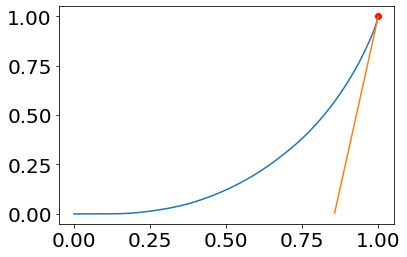

number of remaining indices:  844


In [24]:
lorentz_vals = polycounts['counts'].to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)


vals = np.array(vals)
keys = np.array(keys)

print(len(vals))

L = np.cumsum(vals)/np.sum(vals)

print('Number of cells: ', len(keys))
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 = 1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()
print("number of remaining indices: ", len(polycounts))

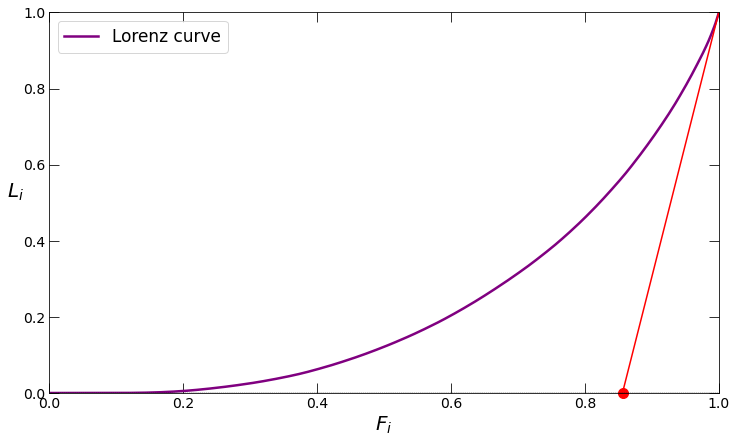

In [25]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.plot(F1, L1, c='purple', lw=2.5, label="Lorenz curve")
ax.plot(F1[tngnt1(F1)>0][0],0, "or", markersize=10, clip_on=False)
ax.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), c='r')
ax.axhline(y=0, linestyle='--', linewidth=0.4, c='k')

plt.xlabel(r'$F_i$', size=20)
plt.ylabel(r'$L_i$',rotation=0, size=20, position=(0,0.6))
ax.yaxis.set_label_coords(-0.05,0.5)
ax.legend(prop={'size': 17})
#ax.legend(['fitted', 'observed'], fontsize=12)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.tick_params(direction="in", size=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

Let's compute the spreading index defined above for a parametrised threshold value for both the original data and its spatially reshuffled version.

  0%|                                                                                          | 0/2 [00:00<?, ?it/s]

844
eta =  1.0
eta =  0.9235544800647916
eta =  0.9092532934395572
eta =  0.8971325794978181
eta =  0.8828327914130235
eta =  0.8758539391708171
eta =  0.8658672864570496
eta =  0.8633029316243337
eta =  0.8574441276076437
eta =  0.846204736981226
eta =  0.8462303550237052
eta =  0.8429817524978269
eta =  0.8345815665549486
eta =  0.8318848607170053
eta =  0.8282452658362182
eta =  0.826815454999745
eta =  0.8184971912468516
eta =  0.8165614346083095
eta =  0.8123661709289693
eta =  0.8113608215771377
eta =  0.8103120662814434
eta =  0.8127091539509099
eta =  0.8002745773821781
eta =  0.7957849876794016
eta =  0.7782798860084577
eta =  0.7745510381114445
eta =  0.7723722046989911
eta =  0.774389792414493
eta =  0.7744377136089242
eta =  0.7765577896011103
eta =  0.7806061966433699
eta =  0.7664261767011802
eta =  0.7616228912432536
eta =  0.7612417435900701
eta =  0.7522288710651668
eta =  0.7481498530846152
eta =  0.7504682318686827
eta =  0.7493059125295922
eta =  0.7569711105021938


<ipython-input-26-bc15114be9d4>:33: RuntimeWarning: Mean of empty slice.
  eta = loubar_dist_corr.mean()/dist_corr.mean()
C:\Users\gevor\anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan
eta =  nan


 50%|█████████████████████████████████████████                                         | 1/2 [00:01<00:01,  1.38s/it]

eta =  nan
844
eta =  1.0
eta =  1.0039128608409145
eta =  1.004676771546656
eta =  1.0060886161514604
eta =  1.0041157458773489
eta =  1.0033769804370527
eta =  1.0119516498215197
eta =  1.012959463015362
eta =  1.016684976940614
eta =  1.022868520478407
eta =  1.023296133318522
eta =  1.0224113401496753
eta =  1.0200878977872232
eta =  1.0141728258091582
eta =  1.015720116252209
eta =  1.015485173474117
eta =  1.01196064106122
eta =  1.0072643328241129
eta =  1.0139119615367578
eta =  1.0181695889158298
eta =  1.0164172865140808
eta =  1.020491864684257
eta =  1.0079234688672851
eta =  1.0098186521054533
eta =  1.0065028577451767
eta =  1.0125736514539005
eta =  1.020946189352348
eta =  1.0180841020332378
eta =  1.0208903634099544
eta =  1.021156007639489
eta =  1.0202328363375976
eta =  1.0254081281237657
eta =  1.028307032549652
eta =  1.0320050204247306
eta =  1.0335989756934219
eta =  1.0245494737563219
eta =  1.029401204920693
eta =  1.0289190946192304
eta =  1.0277969910290616


100%|██████████████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.33s/it]

eta =  nan
eta =  nan


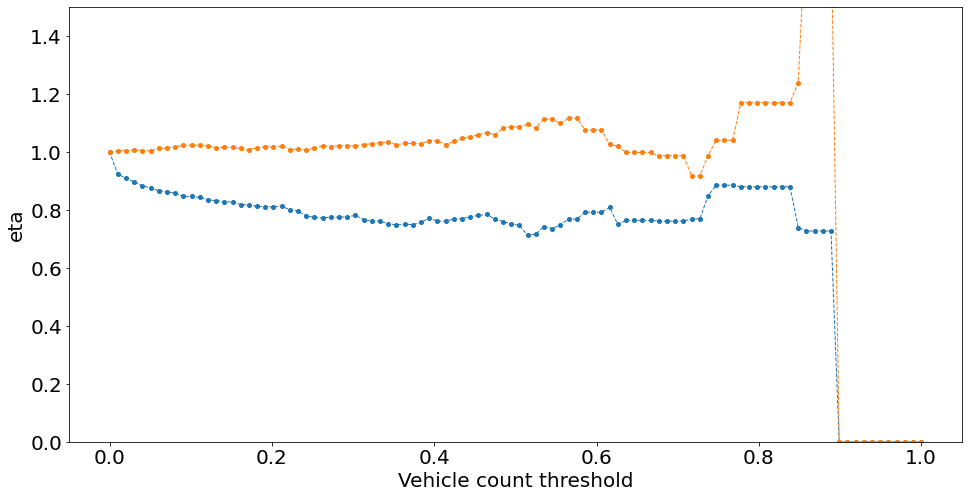

In [26]:
shuffled_distributions = {'Original data': polycounts.counts, 'Shuffled data': polycount_shuffled.counts_shuffled}
shuffled_etas = {}
lval = np.linspace(0, max(polycounts.counts), 100)

# try to wrap the below code in a neat function!
for key, distribution in tqdm(shuffled_distributions.items()):
    lorentz_vals = distribution.to_dict()
    etas = []

    s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
    keys = []
    vals = []
    for k,v in s:
        keys.append(k)
        vals.append(v)


    vals = np.array(vals)
    keys = np.array(keys)
    print(len(vals))

    L = np.cumsum(vals)/np.sum(vals)

    for i in lval:
        loubar_keys = keys[vals>=i]
        dist_mat = eucl[keys.reshape(-1,1), keys]

        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = eucl[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas = np.array(etas)
    etas = np.where(np.isnan(etas), 0, etas)
    shuffled_etas[key] = etas
    
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(16, 8))
for key, eta in shuffled_etas.items():
    ax.plot(lval, eta, linestyle='--', marker='o', markersize=4, linewidth=1)

plt.xlabel("Vehicle count threshold")
plt.ylabel("eta")
plt.ylim(0,1.5)
plt.show()

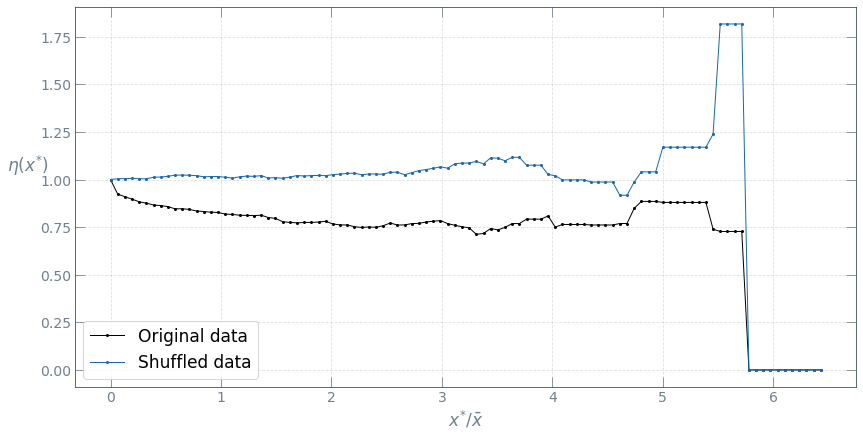

In [27]:
cmap = plt.cm.get_cmap('Blues')
color_dict = {'Original data': 'k', 'Shuffled data': cmap(200)}

fig, ax = plt.subplots(figsize=(14, 7))
lval = np.linspace(0, max(polycounts.counts), 100)/np.mean(polycounts.counts)
for key, eta in shuffled_etas.items():
    ax.plot(lval, eta, linestyle='-', marker='o', markersize=2, linewidth=1, 
            color=color_dict[key], label=key)

ax.legend(prop={'size': 17}, loc=3)
plt.xlabel(r'$x^{*}/\bar{x}$', size=17, color='slategrey')
plt.ylabel(r'$\eta(x^{*})$', size=17, color='slategrey', rotation=0)
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ax.yaxis.set_label_coords(-0.06,0.55)
ax.tick_params(direction="in", size=10)
ax.spines['bottom'].set_color('darkslategrey')
ax.spines['top'].set_color('darkslategrey') 
ax.spines['right'].set_color('darkslategrey')
ax.spines['left'].set_color('darkslategrey')
ax.tick_params(axis='x', colors='slategrey')
ax.tick_params(axis='y', colors='slategrey')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax.grid(alpha=0.4,ls='--')
#plt.savefig('etas.jpg', dpi=120)
plt.show()

As we can see from the plot, the completely random reshuffling (blue line) displays the highest *spreading index* profile, followed by the lower spreading index of the originally observad data (black line).
These two types of *spreading index* profiles make a more or less complete classification of broad mono- versus poly-centric structures to be found in the spatial arrangements of socio-economic quantities in cities. A mono-centric urban configuration will result in a rapid decline of the profile and an overall low *spreading index*, while a polycentric configuration will have an overall high *spreading index*.

In the use case of working with the spatial distibution of vehicle GPS point counts in London, we see that the city has a mostly polycentric spatial structure.

### Exploratory Spatial Data Analysis

Below we will explore the spatial patterns of vehicle GPS trajectories in Rome, aggregate them in the administrative units of the city, identify hotspots and study their statistical significance using rigorous spatial statistical techniques.

In [28]:
# a preliminary dataframe size cutting by eliminating points that fall too far away from the municipal area of Rome.
Rome_gps = data.loc[(data.lon <= 12.8557603) & \
                (data.lat <= 42.1410285) & (data.lon >= 12.2344669) & (data.lat >= 41.6556417)]
len(Rome_gps)

2403877

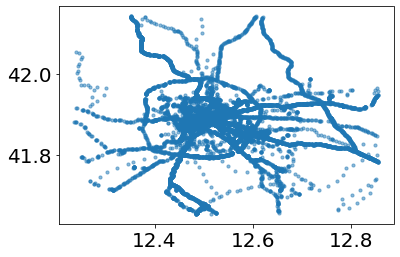

In [29]:
# plot a sample of GPS points in Rome
plt.scatter(Rome_gps.loc[:100000, 'lon'], Rome_gps.loc[:100000, 'lat'], alpha=0.5, s=10)
plt.show()

Let's load the London administrative municipal area geometry file.

Rome shapefile crs:  epsg:32633


(267393.93042270717, 324668.3949759805, 4612038.183198702, 4671650.968422979)

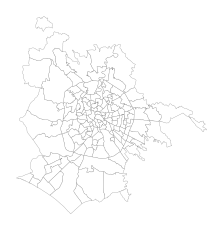

In [30]:
neighborhoods = gpd.read_file('../data/Rome neighbourhoods/ZU_COD.shp')
neighborhoods.plot(linewidth=0.25, edgecolor='grey', color='white')
print('Rome shapefile crs: ', neighborhoods.crs)
plt.axis('off')

In [31]:
#reproject geometry to EPSG:4326
neighborhoods.geometry = neighborhoods.geometry.to_crs(crs)
print(neighborhoods.crs)
neighborhoods.head()

epsg:4326


,Name,ZU,CODZU,TIPZU,MUNICIPIO,GRA,SUPERFICIE,geometry
0,Tuscolano Nord,Tuscolano Nord,9A,1.0,7.0,1.0,107.0,"POLYGON ((12.52509 41.88522, 12.52556 41.88428..."
1,Tuscolano Sud,Tuscolano Sud,9B,1.0,7.0,1.0,316.0,"POLYGON ((12.52989 41.86369, 12.52989 41.86369..."
2,Tor Fiscale,Tor Fiscale,9C,1.0,7.0,1.0,91.0,"POLYGON ((12.53529 41.85882, 12.53604 41.86002..."
3,Appio,Appio,9D,1.0,7.0,1.0,134.0,"POLYGON ((12.50904 41.87505, 12.50885 41.87485..."
4,Latino,Latino,9E,1.0,7.0,1.0,159.0,"POLYGON ((12.50329 41.86663, 12.50329 41.86663..."


Let's extract the GPS point data for Rome similar to how we did it for London above.

In [32]:
Rome_gps = Rome_gps.drop(['heading', 'gps_quality', 'status', 'odometer', 'speed'], axis=1)
Rome_gps.reset_index(drop=True, inplace=True)

# create Point geometries from lat and lon coordinates
geometry = [Point(xy) for xy in zip(Rome_gps.lon, Rome_gps.lat)] #list comprehension
crs = CRS.from_epsg(4326)
gdf_rome = gpd.GeoDataFrame(Rome_gps, crs=crs, geometry=geometry)
gdf_rome.head()

,uid,ts,lat,lon,geometry
0,309332,2015-12-26 07:47:40,41.881481,12.237388,POINT (12.23739 41.88148)
1,309332,2015-12-26 07:48:18,41.875805,12.250631,POINT (12.25063 41.87580)
2,309332,2015-12-26 07:48:56,41.866441,12.259440,POINT (12.25944 41.86644)
3,309332,2015-12-26 07:49:33,41.855236,12.263569,POINT (12.26357 41.85524)
4,309332,2015-12-26 07:50:10,41.846130,12.272366,POINT (12.27237 41.84613)


In [33]:
# carry out the spatial join operation we saw before
neigh_counts = gpd.sjoin(neighborhoods, gdf_rome, op='contains')
neigh_counts.head()

,Name,ZU,CODZU,TIPZU,MUNICIPIO,GRA,SUPERFICIE,geometry,index_right,uid,ts,lat,lon
0,Tuscolano Nord,Tuscolano Nord,9A,1.0,7.0,1.0,107.0,"POLYGON ((12.52509 41.88522, 12.52556 41.88428...",1824686,352812,2015-07-01 04:31:48,41.878480,12.518280
0,Tuscolano Nord,Tuscolano Nord,9A,1.0,7.0,1.0,107.0,"POLYGON ((12.52509 41.88522, 12.52556 41.88428...",2197237,361112,2015-10-04 19:34:56,41.878390,12.518485
0,Tuscolano Nord,Tuscolano Nord,9A,1.0,7.0,1.0,107.0,"POLYGON ((12.52509 41.88522, 12.52556 41.88428...",2197236,361112,2015-10-04 19:34:25,41.878390,12.518485
0,Tuscolano Nord,Tuscolano Nord,9A,1.0,7.0,1.0,107.0,"POLYGON ((12.52509 41.88522, 12.52556 41.88428...",523017,321272,2015-04-25 15:39:39,41.878401,12.518453
0,Tuscolano Nord,Tuscolano Nord,9A,1.0,7.0,1.0,107.0,"POLYGON ((12.52509 41.88522, 12.52556 41.88428...",119338,313722,2015-08-31 10:07:42,41.878413,12.518363


In [34]:
counts = neigh_counts.groupby(neigh_counts.index)['index_right'].count()
counts = pd.DataFrame(counts)
counts.columns = ['counts']
counts

,counts
0,13760
1,17003
2,1878
3,14888
4,2295
...,...
150,17044
151,11255
152,35662
153,12321


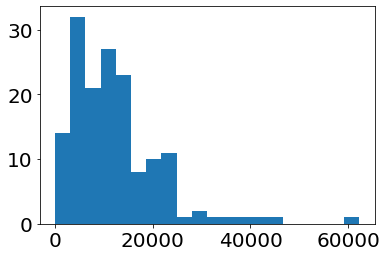

In [35]:
plt.hist(counts.counts, bins=20)
plt.show()

In [36]:
polycounts = neighborhoods.copy()
polycounts['counts'] = counts.counts
polycounts['counts'].fillna(0, inplace=True)
polycounts['counts'] = polycounts['counts'].astype(int)
polycounts

,Name,ZU,CODZU,TIPZU,MUNICIPIO,GRA,SUPERFICIE,geometry,counts
0,Tuscolano Nord,Tuscolano Nord,9A,1.0,7.0,1.0,107.0,"POLYGON ((12.52509 41.88522, 12.52556 41.88428...",13760
1,Tuscolano Sud,Tuscolano Sud,9B,1.0,7.0,1.0,316.0,"POLYGON ((12.52989 41.86369, 12.52989 41.86369...",17003
2,Tor Fiscale,Tor Fiscale,9C,1.0,7.0,1.0,91.0,"POLYGON ((12.53529 41.85882, 12.53604 41.86002...",1878
3,Appio,Appio,9D,1.0,7.0,1.0,134.0,"POLYGON ((12.50904 41.87505, 12.50885 41.87485...",14888
4,Latino,Latino,9E,1.0,7.0,1.0,159.0,"POLYGON ((12.50329 41.86663, 12.50329 41.86663...",2295
...,...,...,...,...,...,...,...,...,...
150,Acqua Vergine,Acqua Vergine,8D,1.0,6.0,0.0,1124.0,"POLYGON ((12.66105 41.89974, 12.66139 41.89887...",17044
151,Lunghezza,Lunghezza,8E,1.0,6.0,0.0,1252.0,"POLYGON ((12.65303 41.91838, 12.65321 41.91881...",11255
152,Torre Angela,Torre Angela,8F,1.0,6.0,0.0,1649.0,"POLYGON ((12.61507 41.89326, 12.62042 41.89326...",35662
153,Borghesiana,Borghesiana,8G,1.0,6.0,0.0,2356.0,"POLYGON ((12.72560 41.83319, 12.72494 41.83427...",12321


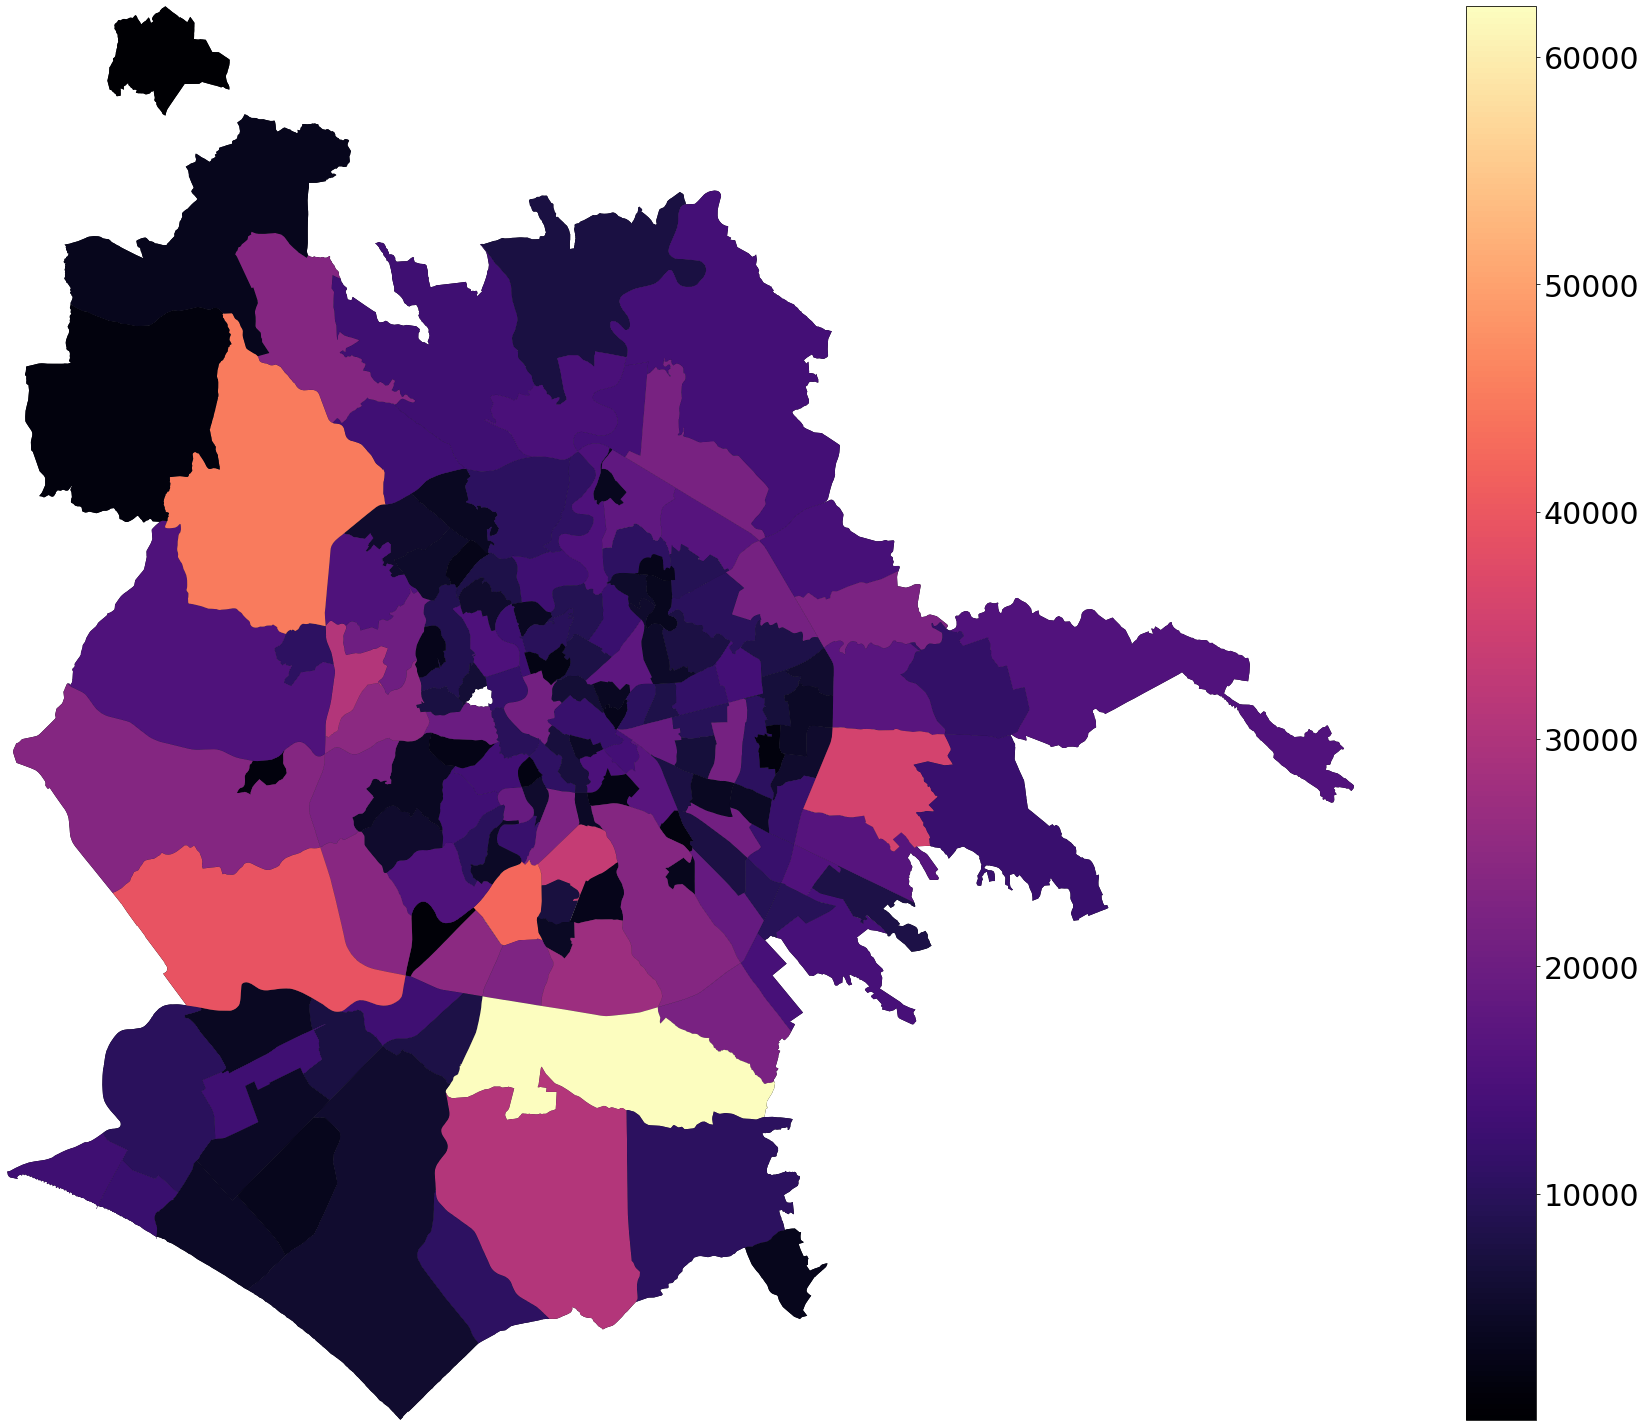

In [37]:
# plot the vehicle count distribution
plt.rcParams.update({'font.size':30})
west, south, east, north = neighborhoods.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

neighborhoods.plot(ax=ax, color='#000004')
polycounts.plot(column='counts',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
ax.axis('off')
plt.show()

Notice the weird spatial arrangement of vehicle counts that fall within each administrative unit? You might have guessed that the central areas should contain most vehicle points, and you would have been right! However, the reason you see a different picture is the so-called [Modifiable Aerial Unit Problem](https://en.wikipedia.org/wiki/Modifiable_areal_unit_problem#:~:text=The%20modifiable%20areal%20unit%20problem%20(MAUP)%20is%20a%20source%20of,results%20of%20statistical%20hypothesis%20tests.&text=Thus%20the%20results%20of%20data,to%20use%20in%20their%20analysis.). Whenever you come across spatial data and have to aggregate them into spatial aerial units, always ask yourself what you are trying to achieve, and do a post study sanity check to make sure the aerial units do not change your analysis results.

<AxesSubplot:>

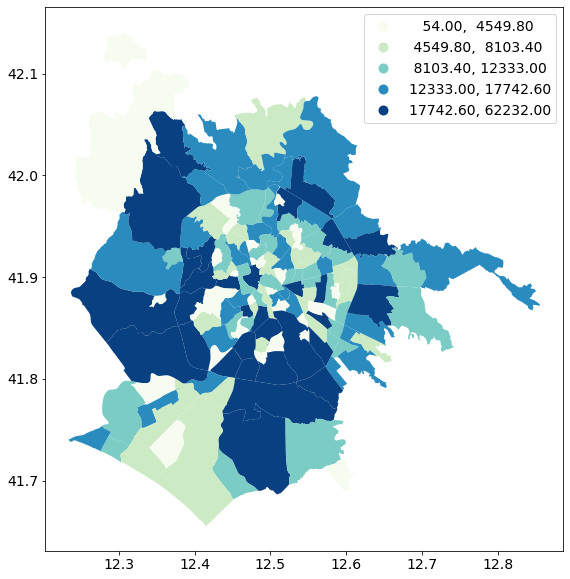

In [38]:
plt.rcParams.update({'font.size':14})
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
polycounts.plot(column='counts', scheme='Quantiles', k=5, cmap='GnBu', legend=True, ax=ax)

Now we will use something called **spatial weights** - a method to identify the spatial arrangements of geometries in relation to each other by constructing a spatial binary graph that encodes geometric neighbours.

Spatial weights are typically of **Rook** and **Queen** contiguity types. **Rook** contiguity requires that the pair of polygons in question share an edge. **Queen** contiguity, on the other hand, requires that polygons share a common vertex, and hence is a weaker type of contiguity.

3.0468262226847034


C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 99, 113.
  warnings.warn(message)


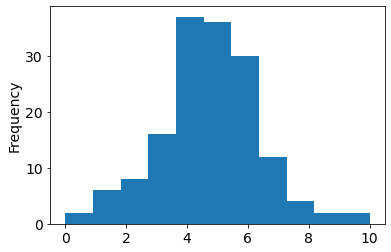

In [39]:
# let's plot the distribution of neighbour counts
wr = lps.weights.contiguity.Rook.from_dataframe(polycounts)
print(wr.pct_nonzero)
s = pd.Series(wr.cardinalities)
s.plot.hist(bins=s.unique().shape[0]);

In [40]:
wq = lps.weights.Queen.from_dataframe(polycounts)
# row standardisation
wq.transform = 'r'

('WARNING: ', 99, ' is an island (no neighbors)')
('WARNING: ', 113, ' is an island (no neighbors)')


Here we might see an important warning: some polygons are isolated and do not have any neighbours. This can cause serious problems later in the analysis, so it is common practice to make changes in the contiguity matrix before using it. The first approach we take is to find the nearest neighbor for the isolated (island) observation and then add this pair of neighbors to increase the neighbor pairs from the original contiguity weight to obtain a fully connected set of weights.

C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\U

C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\U

C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\U

C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\U

C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\U

C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\U

C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1294: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = gdf.loc[neighbors].centroid.apply(lambda p: (p.x, p.y))
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1305: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.apply(lambda p: p.x),
C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:1306: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf.centroid.apply(lambda p: p.y),


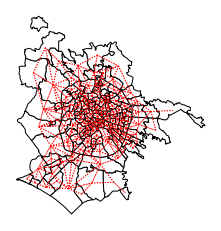

In [41]:
ax = polycounts.plot(edgecolor='k', facecolor='w')
wq.plot(polycounts, ax=ax, 
        edge_kws=dict(color='r', linestyle=':', linewidth=1),
        node_kws=dict(marker=''))
ax.set_axis_off()

Below we use the "neighbours" attribute of the spatial weight class to obtain a dictionary of neighbours for each polygon we have in our data set.

In [42]:
wq.neighbors

{0: [1, 3, 4, 83, 85, 135, 109],
 1: [0, 2, 3, 4, 6, 135, 137, 23],
 2: [1, 7, 6, 23, 137],
 3: [0, 1, 83, 4, 19, 85, 86],
 4: [0, 1, 3, 19, 86, 23],
 5: [145, 147, 6, 137, 10, 9],
 6: [1, 2, 5, 7, 137, 9],
 7: [2, 6, 8, 9, 13, 15, 23, 24],
 8: [7, 23],
 9: [5, 6, 7, 10, 11, 13],
 10: [147, 148, 5, 149, 9, 11],
 11: [148, 149, 9, 10, 12, 13, 14],
 12: [11, 13, 14],
 13: [7, 9, 11, 12, 15],
 14: [11, 12, 149],
 15: [24, 7, 13, 23],
 16: [48, 81, 82, 18, 17, 58],
 17: [16, 48, 18, 50, 25],
 18: [16, 81, 17, 19, 20, 86, 25],
 19: [81, 18, 3, 4, 20, 86, 23],
 20: [18, 19, 21, 22, 23, 25],
 21: [25, 26, 20, 22],
 22: [20, 21, 23, 26, 29],
 23: [1, 2, 4, 7, 8, 15, 19, 20, 22, 24, 29],
 24: [32, 23, 7, 29, 15],
 25: [17, 50, 18, 20, 21, 51, 26, 27, 28],
 26: [21, 22, 25, 28, 29],
 27: [32, 37, 25, 28, 30, 31],
 28: [32, 25, 26, 27, 29, 31],
 29: [32, 22, 23, 24, 26, 28],
 30: [52, 37, 38, 54, 27, 31, 47],
 31: [32, 38, 27, 28, 30, 47],
 32: [33, 34, 47, 24, 27, 28, 29, 31],
 33: [32, 34, 35, 

We see that polygons 99 and 113 indeed have an empty list of neighbours.

In [43]:
disconnected_neighs = polycounts.iloc[[99, 113]]
disconnected_neighs

,Name,ZU,CODZU,TIPZU,MUNICIPIO,GRA,SUPERFICIE,geometry,counts
99,Martignano,Martignano,20O,0.0,15.0,0.0,1081.0,"POLYGON ((12.29979 42.13675, 12.30006 42.13624...",54
113,Val Melaina,Val Melaina,4B,1.0,3.0,1.0,319.0,"POLYGON ((12.53985 41.95259, 12.53996 41.95230...",10641


In [44]:
wq[113]

{}

We will connect these observations to their nearest neighbors. To do this, we can build the KNN graph, a neighbourhood matrix functionality PySal offers, but set k=1, so observations are only assigned to their nearest neighbor:

In [45]:
wk1 = lps.weights.distance.KNN.from_dataframe(polycounts, k=1)

C:\Users\gevor\anaconda3\lib\site-packages\libpysal\weights\weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 40 disconnected components.
  warnings.warn(message)


In this graph, all our observations are connected to **only one** other observation by construction:

In [46]:
pd.Series(wk1.cardinalities).unique()

array([1], dtype=int64)

So are, as expected, the two isolated polygons we had identified:

In [47]:
print("Neighbour of isolated polygon 113: ", wk1.neighbors[113])
print("Neighbour of isolated polygon 99: ", wk1.neighbors[99])

Neighbour of isolated polygon 113:  [117]
Neighbour of isolated polygon 99:  [98]


To connect them in our initial matrix, we need to create a copy of the **neighbors** dictionary and update the entries for 99 and 113, including 117 and 98 as their neighbours, respectively. So, first we copy the neighbors:

In [48]:
neighbors = wq.neighbors.copy()

Append the nearest neighbours we have found using the KNN graph:

In [49]:
neighbors[99].append(98)
neighbors[98].append(99)
neighbors[113].append(117)
neighbors[117].append(113)

and assign the new weights to a new variable we will be using for the rest of the exercise:

In [50]:
w_new = lps.weights.W(neighbors)

### Spatial Autocorrelation

We always look for patterns when inspecting a city. If the spatial distribution of the values in the city was random, then we should not see any clustering of similar values on the map. However, our brain easily captures the darker clusters in certain parts of the city.

Our brains are very powerful pattern recognition machines. However, sometimes they can be deceptive and misleading and lead us to detect false positives, or patterns where there are no statistically significant patterns. This happens typically when dealing with visualization of irregular polygons of differing sizes and shapes. Making consistent visual comparisons then becomes difficult.

The concept of spatial autocorrelation relates to the combination of two types of similarity: **spatial similarity** and **attribute similarity**. We have already seen spatial similarity when we talked about spatial weights: how similarly are geometric entities located in space. Attribute similarity is concerned with the similarity of values within the overall distribution of the attribute data. Although there are many different measures of spatial autocorrelation, they all combine these two types of simmilarity into a summary measure.

To sum up, the spatial weight between neighborhoods  _i_  and  _j_  indicates if the two are geographical neighbors (i.e., spatially similar). What we also need is a measure of attribute similarity to supplement this concept of spatial similarity. The spatial lag is a derived variable that accomplishes this for us. For neighborhood  i  the spatial lag is defined as:

$$
\text { ylag }_{i}=\sum_{j} w_{i, j} y_{j}
$$

If you pay a closer attention to the formula, you'll notice that it simply takes a weighted average of a neighbourhood's neighbours. It acts essentially as a local smoother.

In [51]:
len(neighbors)

155

In [52]:
y = polycounts['counts']
ylag = lps.weights.lag_spatial(w_new, y)
print(ylag)

[ 73048.  91098.  75018.  61378.  81190.  45360.  75473.  91913.  42630.
  84828.  78697.  81928.  33164.  72150.  46426.  74243.  80153.  93831.
 115864. 114912. 103936.  83636.  96395. 148133. 146382. 147367. 103079.
 149173. 169099. 138367. 109886. 135670. 151279.  88534.  96507.  36275.
  10338. 116670.  87249.  69920.  26220.  44153.  90965.  22269.  27684.
  35683.  14619. 144475.  58886.  52339.  99435. 100854. 123574.  57232.
 105356.  67720. 125397. 131404.  86861.  39010. 127213.  37339.  80290.
 155354. 131804.  59521. 106737. 160173.  98502.  88051.  83059. 117398.
  56992.  54058. 119356.  63721.  80912.  44942.  84977.  62859.  78663.
  86042.  39387.  70723.  65895.  47805.  92754.  57512.  36610.  57750.
  61316.  79841.  67410. 101543.  74576.  73719.  41749.  84679.  70416.
   3283.  49145.  58209.  36258.  77673.  78695.  60385.  51605.  62445.
  51161.  65734.  37610.  56800.  45544.   5121.  47341.  70951.  85187.
  50315.  43407.  18148.  33115. 100750.  98287.  9

In [53]:
import mapclassify as mc
ylagq5 = mc.Quantiles(ylag, k=5)

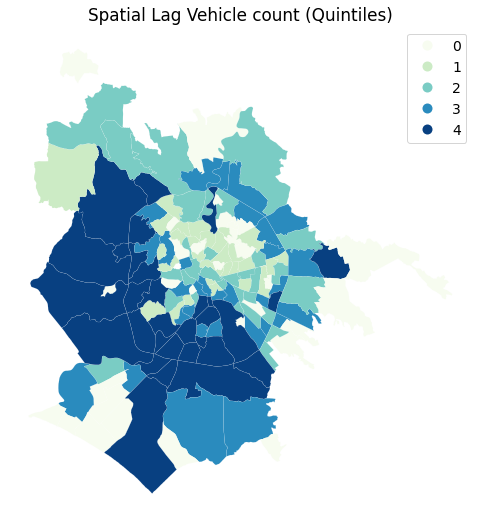

In [54]:
f, ax = plt.subplots(1, figsize=(9, 9))
polycounts.assign(cl=ylagq5.yb).plot(column='cl', categorical=True, \
        k=5, cmap='GnBu', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("Spatial Lag Vehicle count (Quintiles)")

plt.show()

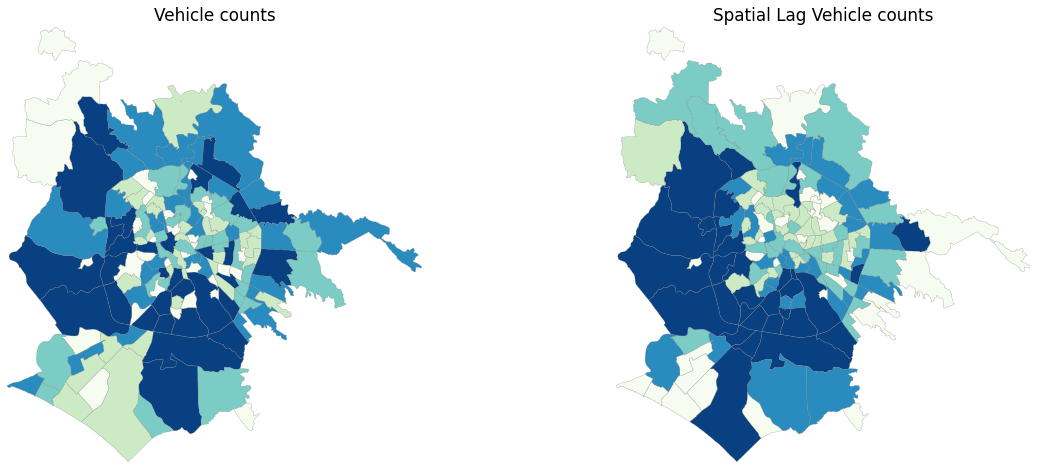

In [55]:
polycounts['lag_counts'] = ylag
f, ax = plt.subplots(1,2,figsize=(20,8))
polycounts.plot(column='counts', ax=ax[0], edgecolor='grey', linewidth=0.25,
        scheme="quantiles",  k=5, cmap='GnBu')
ax[0].axis(polycounts.total_bounds[np.asarray([0,2,1,3])])
ax[0].set_title("Vehicle counts")
polycounts.plot(column='lag_counts', ax=ax[1], edgecolor='grey', linewidth=0.25,
        scheme='quantiles', cmap='GnBu', k=5)
ax[1].axis(polycounts.total_bounds[np.asarray([0,2,1,3])])
ax[1].set_title("Spatial Lag Vehicle counts")
ax[0].axis('off')
ax[1].axis('off')
plt.show()

However, we still have to visually associate the value of the vehicle counts in a neighbourhood with the value of the spatial lag of values for that neighbourhood.

To make our approach rigorous and consistent, we shall turn to formal statistical measures of spatial autocorrelation.

### Global Spatial Autocorrelation

We begin with the simple case where the variable under consideration is binary. This is useful to unpack the logic of spatial autocorrelation tests and gain a firm intuition of how it works. So even though our attribute is continuous, we will convert it to a binary case to illustrate the key concepts:

In [56]:
y.median()

10425.0

In [57]:
yb = y > y.median()
sum(yb)

77

We have 77 neighborhoods with vehicle count attribute values above the median and the rest below the median.

In [58]:
yb = y > y.median()
labels = ["0 Low", "1 High"]
yb = [labels[i] for i in 1*yb] 
polycounts['yb'] = yb

The spatial distribution of the binary variable is first of all visually calling for a "black and white" arrangement, that we can then analyse with formal statistical procedures, as mentioned above.

<AxesSubplot:>

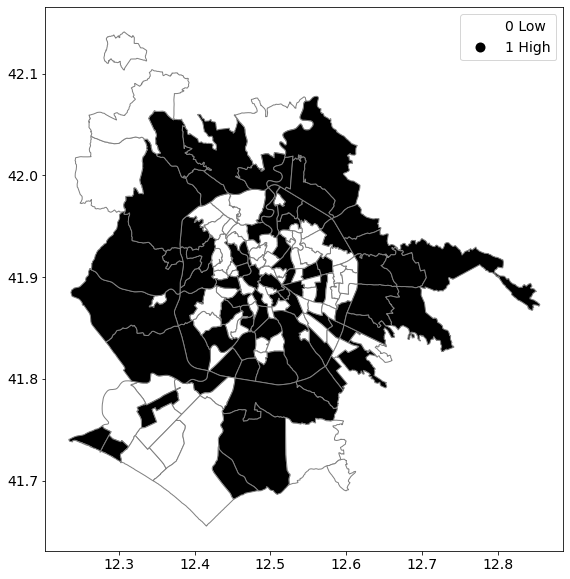

In [59]:
fig, ax = plt.subplots(figsize=(12,10), subplot_kw={'aspect':'equal'})
polycounts.plot(column='yb', cmap='binary', edgecolor='grey', legend=True, ax=ax)

#### Join counts 

One way to consider a statistical test for spatial autocorrelation in a binary variable is to look at the so-called joins. A join reflects the spatial relationship between each neighbor pair of observations, and the joins are reflected in our binary spatial weights object **wq**.

Each unit can take on one of two values "Black" or "White", and so for a given pair of neighboring locations there are three different types of joins that can arise:

* Black Black (BB)
* White White (WW)
* Black White (or White Black) (BW)

Given that we have 77 Black polygons on our map, what is the number of Black Black (BB) joins we could expect if the process were such that the Black polygons were **randomly assigned** on the map? Just like any other statistical test, this is the intuition behind join count statistics.

We can use the ESDA package from PySAL to carry out join count analysis:

In [60]:
import esda 
yb = 1 * (y > y.median()) # convert back to binary
#wq =  lps.weights.Queen.from_dataframe(polycounts)
w_new.transform = 'b'
np.random.seed(12345)
jc = esda.join_counts.Join_Counts(yb, w_new)

In [61]:
jc.bb

135.0

In [62]:
jc.ww

102.0

In [63]:
jc.bw

204.0

Note that the three cases exhaust all possibilities:

In [64]:
jc.bb + jc.ww + jc.bw

441.0

In [65]:
w_new.s0 / 2

441.0

which is the unique number of joins in the spatial weights object.

The crucial question is whether this is a departure from what we would expect if the process generating the spatial distribution of the Black polygons were a completely random one. To answer this, PySAL uses random spatial permutations of the observed attribute values to generate a realization under the null hypothesis of complete spatial randomness (CSR). This is repeated a large number of times (999 by default) to construct a reference distribution against which to evaluate the statistical significance of our observed counts.

The average number of BB joins from the synthetic realizations is:

In [66]:
jc.mean_bb

108.3943943943944

which is less than our observed count. How much less? The question is whether our observed value is so different from the expectation that we would reject the null hypothesis of complete spatial randomness?

In [67]:
sim_array = jc.sim_bb
sim_array = sim_array.astype(float)
sim_array

array([110., 116., 125., 109., 102., 113., 113., 113., 118., 106., 101.,
       119., 116., 106., 108., 113., 106., 113., 119., 112., 110., 104.,
       114., 109.,  97., 104., 111., 110., 110., 104., 107., 115., 114.,
       114., 113., 112., 112., 102., 119.,  99., 101., 104., 108., 118.,
       101., 125., 109., 117.,  99., 106., 105., 103., 123., 119.,  95.,
       111., 107.,  98., 112.,  98., 104., 116., 114., 109., 109., 119.,
       105.,  99., 125., 118., 103., 115., 108., 114.,  96., 106., 104.,
       101., 115., 112., 102., 119., 106., 108., 119., 113., 118., 101.,
       116., 115., 107., 115., 114., 112., 114., 105., 110., 113., 127.,
       114.,  95., 110., 111.,  91., 111., 110., 116., 109., 112., 102.,
        93.,  94., 111., 105., 105., 118., 114., 112., 109., 111., 118.,
       108., 120., 105., 102., 118.,  99.,  99., 104., 110., 118., 109.,
       110., 112., 110.,  96.,  91.,  97.,  97.,  99., 111.,  99., 102.,
       105., 128., 110.,  86., 111.,  85., 115., 11

Text(0.5, 0, 'BB Counts')

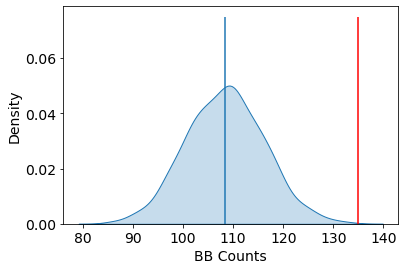

In [68]:
import seaborn as sbn
sbn.kdeplot(sim_array, shade=True)
plt.vlines(jc.bb, 0, 0.075, color='r')
plt.vlines(jc.mean_bb, 0,0.075)
plt.xlabel('BB Counts')

The density displays the distribution of the BB counts, with the black vertical line showing the mean BB count from the simulated realizations and the red line the observed BB count for our vehicle count values. Clearly our observed value is very high, at the tail of the distribution. A pseudo p-value summarizes this:

In [69]:
jc.p_sim_bb

0.001

Since this is below conventional statistical significance levels, we would reject the null hypothesis of complete spatial randomness in favor of spatial autocorrelation in vehicle GPS point distribution in the city.

#### Continuous Case 

The join count analysis is based on a binary variable, which can cover many interesting empirical applications where one is interested in presence and absence of some kind of phenomena. In our case, we artificially created the binary attribute for demonstration purposes, and in the process we threw away a lot of valuable information in our originally continuous attribute. Turning back to the original variable, we can explore other tests for spatial autocorrelation for the continuous case.

First, we transform our weights to be row-standardized, from the current binary state:

In [70]:
w_new.transform = 'r'
y = polycounts['counts']

Moran's I is a test for global autocorrelation for a continuous attribute and is defined as:

$$
I=\frac{N}{W} \frac{\sum_{i} \sum_{j} w_{i j}\left(x_{i}-\bar{x}\right)\left(x_{j}-\bar{x}\right)}{\sum_{i}\left(x_{i}-\bar{x}\right)^{2}}
$$

where $N$ is the number of spatial units indexed by $i$ and $j$; $x$ is the variable of interest; ${\bar {x}}$ is the mean of $x$; $w_{ij}$ is a matrix of spatial weights with zeroes on the diagonal (i.e., $w_{ii}=0$); and $W$ is the sum of all $w_{ij}$.

In [71]:
np.random.seed(12345)
mi = esda.moran.Moran(y, w_new)
mi.I

0.12873081752819687

Just as before, our value for the Moran's I statistic needs to be interpreted against a reference distribution under the null hypothesis of CSR. PySAL uses a similar approach as we saw in the join count analysis: random spatial permutations.

Text(0.5, 0, "Moran's I")

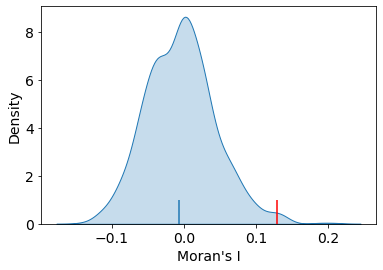

In [72]:
import seaborn as sbn
sbn.kdeplot(mi.sim, shade=True)
plt.vlines(mi.I, 0, 1, color='r')
plt.vlines(mi.EI, 0,1)
plt.xlabel("Moran's I")

In [73]:
mi.p_sim

0.011

Here we see a statistically **not** significant result, and thus we are unable to reject the null hypothesis of spatial randomness. Incidentally, domain expertise from the field of urban mobility tells us that this result is actually wrong, that is, it's a false negative. GPS vehicle trajectories form firmly non-random spatial patterns. This is a demonstration of the limitations of spatial statistical measures that you should always bear in mind.

#### Local Autocorrelation: Hot Spots, Cold Spots, and Spatial Outliers 

In addition to the _Global_ autocorrelation statistics, PySAL has many _local_ autocorrelation statistics. Let's compute a local Moran statistic for the same data:

In [74]:
w_new.transform = 'r'
lag_vehicle_counts = lps.weights.lag_spatial(w_new, polycounts['counts'])

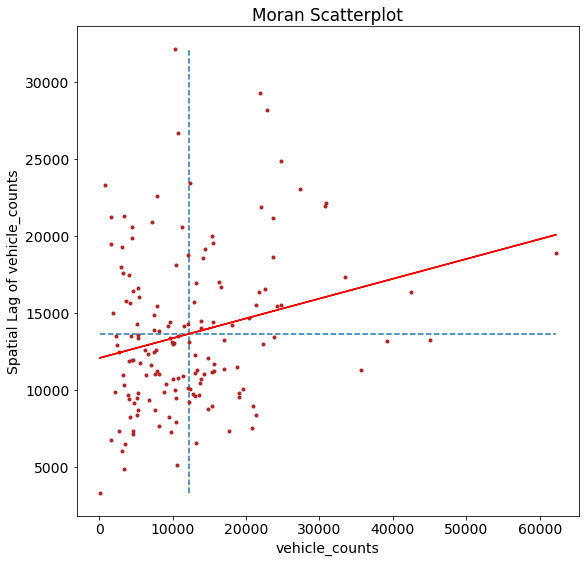

In [75]:
vehicle_counts = polycounts['counts']
b, a = np.polyfit(vehicle_counts, lag_vehicle_counts, 1)
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(vehicle_counts, lag_vehicle_counts, '.', color='firebrick')

 # dashed vert at mean of the vehicle_counts
plt.vlines(vehicle_counts.mean(), lag_vehicle_counts.min(), lag_vehicle_counts.max(), linestyle='--')
 # dashed horizontal at mean of lagged vehicle_counts 
plt.hlines(lag_vehicle_counts.mean(), vehicle_counts.min(), vehicle_counts.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(vehicle_counts, a + b*vehicle_counts, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of vehicle_counts')
plt.xlabel('vehicle_counts')
plt.show()

Now, instead of a single  Moran's I  statistic, we have an array of local  $I_i$  statistics, stored in the ".Is" attribute, and p-values from the simulation are stored in "p_sim".

In [76]:
li = esda.moran.Moran_Local(y, w_new)
li.q

array([4, 4, 2, 4, 2, 4, 2, 4, 2, 2, 1, 4, 4, 2, 2, 1, 2, 2, 1, 2, 1, 2,
       2, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 2, 2, 3, 2, 2, 2, 4, 3, 2, 4,
       4, 3, 3, 2, 4, 2, 2, 1, 1, 2, 1, 4, 2, 1, 4, 2, 1, 2, 4, 1, 1, 2,
       2, 1, 3, 1, 2, 1, 3, 2, 1, 2, 4, 4, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4,
       3, 3, 3, 3, 2, 1, 1, 1, 2, 4, 2, 3, 3, 3, 3, 4, 3, 4, 2, 3, 4, 3,
       3, 3, 3, 3, 2, 1, 1, 3, 3, 3, 3, 4, 1, 1, 1, 3, 3, 3, 4, 1, 2, 3,
       3, 1, 1, 4, 2, 3, 2, 4, 3, 3, 3, 3, 2, 3, 3, 2, 2, 1, 1, 2, 4, 1,
       4])

We can again test for local clustering using permutations, but here we use conditional random permutations (different distributions for each focal location)

In [77]:
(li.p_sim < 0.05).sum()

22

We can distinguish the specific type of local spatial association reflected in the four quadrants of the Moran Scatterplot above:

In [78]:
sig = li.p_sim < 0.05
hotspot = sig * li.q==1
coldspot = sig * li.q==3
doughnut = sig * li.q==2
diamond = sig * li.q==4

In [79]:
spots = ['n.sig.', 'hot spot']
labels = [spots[i] for i in hotspot*1]

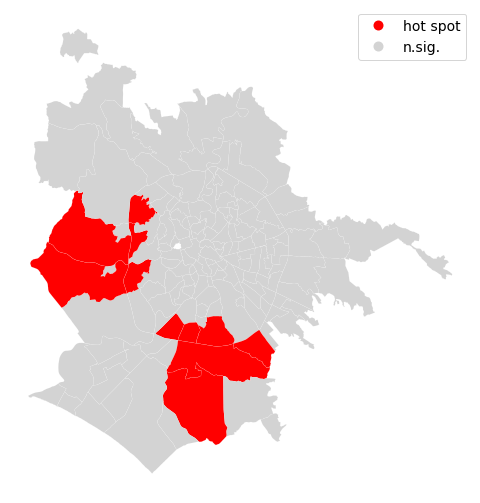

In [80]:
from matplotlib import colors
hmap = colors.ListedColormap(['red', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
polycounts.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [81]:
spots = ['n.sig.', 'cold spot']
labels = [spots[i] for i in coldspot*1]

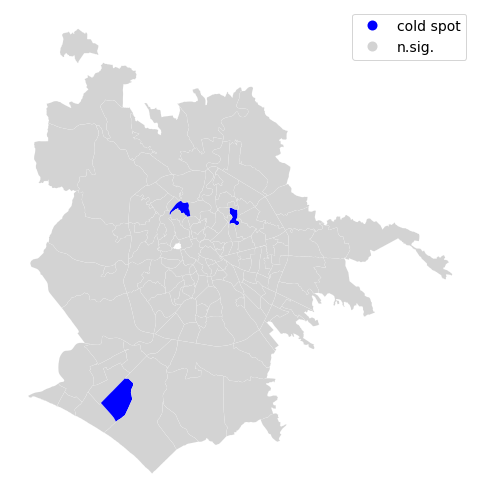

In [82]:
hmap = colors.ListedColormap(['blue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
polycounts.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [83]:
spots = ['n.sig.', 'doughnut']
labels = [spots[i] for i in doughnut*1]

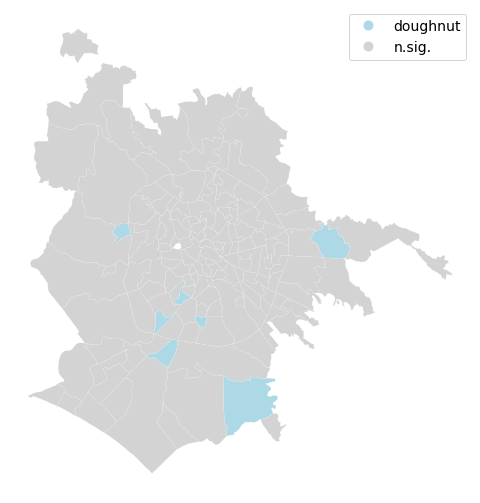

In [84]:
hmap = colors.ListedColormap(['lightblue', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
polycounts.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [85]:
spots = ['n.sig.', 'diamond']
labels = [spots[i] for i in diamond*1]

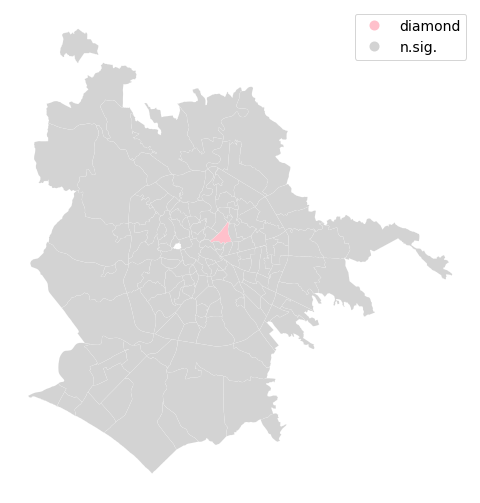

In [86]:
hmap = colors.ListedColormap(['pink', 'lightgrey'])
f, ax = plt.subplots(1, figsize=(9, 9))
polycounts.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

In [87]:
sig = 1 * (li.p_sim < 0.05)
hotspot = 1 * (sig * li.q==1)
coldspot = 3 * (sig * li.q==3)
doughnut = 2 * (sig * li.q==2)
diamond = 4 * (sig * li.q==4)
spots = hotspot + coldspot + doughnut + diamond
spots

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 2, 1, 1, 1, 0, 2, 1, 1, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,
       2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0,
       0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0])

In [88]:
spot_labels = [ '0 ns', '1 hot spot', '2 doughnut', '3 cold spot', '4 diamond']
labels = [spot_labels[i] for i in spots]

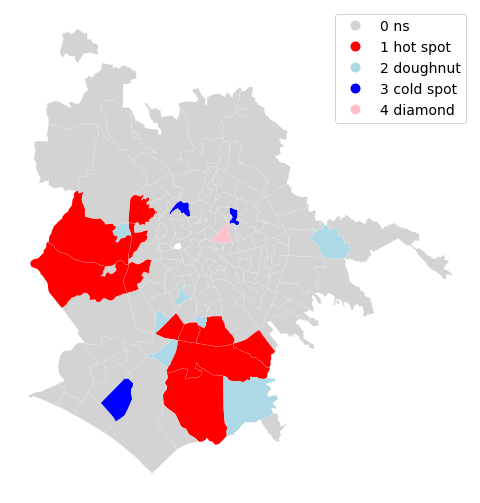

In [89]:
hmap = colors.ListedColormap([ 'lightgrey', 'red', 'lightblue', 'blue', 'pink'])
f, ax = plt.subplots(1, figsize=(9, 9))
polycounts.assign(cl=labels).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.show()

### Homework assignments

1. Go to the [Airbnb listings data](http://insideairbnb.com/get-the-data.html), pick **two cities** of your choice, then load the OpenStreetMap city polygons for those cities with `osmnx`, subdivide them into grid cells of size 500-1000m, load all banks in those cities and compute the spreading index profiles for the spatial distributions of banks in both cities and plot them on the same plot.

2. From the [Airbnb listings data](http://insideairbnb.com/get-the-data.html), get the neighbourhood files for one of the cities chosen above and conduct the spatial autocorrelation analysis you learned in this class for the banks in that city. 

For the first task, submit a .JPG or .PNG file with the final plot to Moodle. Complete the second task in a clean Jupyter Notebook, name the notebook **< Name > < Surname > Class 4 Homework** and upload it to Moodle.